In [ ]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 621 (delta 166), reused 143 (delta 89), pack-reused 393 (from 1)
Receiving objects: 100% (621/621), 30.17 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/ELENA/ELENA


In [ ]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving ah_pot.m to ah_pot.m


In [ ]:
#!/usr/bin/env python3
"""
Generic converter from a Mathematica DRalgo-style potential

    V[field_, T_] := expr

to a Python module potential_3d.py with

    def V(phi, T)
    def dV(phi, T)

that is numerically stable and ELENA-compatible.

- Works for ANY thermal potential with one scalar field and temperature T.
- Automatically detects all other symbols as parameters that must be provided
  by get_params(T).

Usage:
  1. Put your Mathematica definition (one line) into INPUT_FILE
     e.g.:
       V[phi_, T_] := (msq*ϕ^2)/2 + (λ*ϕ^4)/4 - ...

  2. Run:
       python generate_potential_generic.py

  3. You get `potential_3d.py`. Open it and implement get_params(T).
"""

import sympy as sp
from pathlib import Path
import re

# You already set this:
INPUT_FILE  = "ah_pot.m"
OUTPUT_FILE = "potential_3d.py"


# ------------------------------------------------------------------
# Helpers: Mathematica → SymPy-friendly string
# ------------------------------------------------------------------

# Common symbol name mappings used by DRalgo / SM / BSM models
MMA_SYMBOL_MAP = {
    # Field aliases (Unicode & escaped forms)
    "ϕ": "phi",
    "φ": "phi",
    "\\[CurlyPhi]": "phi",
    "\\[Phi]": "phi",

    # Lambdas
    "λ": "lam",
    "\\[Lambda]": "lam",
    "\\[Lambda]1H": "lam1H",

    # Mus / renormalisation scales
    "μ3US": "mu3US",
    "\\[Mu]3US": "mu3US",
    "\\[Mu]": "mu",

    # Hypercharges / generic charges / angles
    "Yϕ": "Yphi",
    "\\[Alpha]": "alpha",
    "\\[Beta]": "beta",

    # Standard Mathematica builtins
    "Pi": "pi",
    "Sqrt": "sqrt",
    "Log": "log",
}


def extract_def_line(mathematica_str: str):
    """
    Find the last definition line of the form

        V[field_, T_] := expr

    and return:

        field_name, T_name, rhs_string

    with field_name / T_name stripped of underscores.
    """
    lines_with_def = [ln for ln in mathematica_str.splitlines() if ":=" in ln]
    if not lines_with_def:
        raise ValueError("Could not find ':=' in input file.")

    last = lines_with_def[-1]

    # Extract the part between 'V[' and ']:='
    try:
        inside = last.split("V[", 1)[1].split("]:=", 1)[0]
    except IndexError as e:
        raise ValueError(
            "Could not parse the V[field_, T_] definition line. "
            "Make sure it has the form 'V[phi_, T_] := ...'."
        ) from e

    # Split arguments: e.g. "phi_, T_" -> "phi_", "T_"
    parts = [p.strip() for p in inside.split(",")]
    if len(parts) != 2:
        raise ValueError(
            f"Expected two arguments in V[...], found: {inside!r}"
        )

    field_part, T_part = parts
    field_name = field_part.replace("_", "").strip()
    T_name     = T_part.replace("_", "").strip()

    rhs = last.split(":=", 1)[1].strip()
    return field_name, T_name, rhs


def mathematica_to_sympy(expr: str) -> str:
    """
    Generic textual conversion from Mathematica syntax to something SymPy can parse.
    Handles:
      - greek / escaped letters like ϕ, \\[CurlyPhi], λ, \\[Lambda]1H, μ3US, \\[Mu]3US
      - Pi, Sqrt, Log
      - power ^ to **
      - [ ] to ( )
    Everything else is left untouched so it's model-agnostic.
    """
    # Symbol-level replacements
    for old, new in MMA_SYMBOL_MAP.items():
        expr = expr.replace(old, new)

    # Structural replacements
    expr = expr.replace("^", "**")
    expr = expr.replace("[", "(")
    expr = expr.replace("]", ")")
    return expr


def make_half_powers_safe(expr: sp.Expr) -> sp.Expr:
    """
    Replace half-integer powers x^(n/2) with Abs(x)^(n/2) to avoid complex/NaN
    when x is slightly negative due to numerics.

    This catches things like (msq + lam*phi**2)**(3/2), ( ... )**(1/2), etc.
    """

    def repl_pow(e):
        if isinstance(e, sp.Pow) and isinstance(e.exp, sp.Rational) and e.exp.q == 2:
            # e.base**(m/2)  ->  Abs(e.base)**(m/2)
            return sp.Pow(sp.Abs(e.base), e.exp)
        return e

    return expr.replace(
        lambda e: isinstance(e, sp.Pow)
        and isinstance(e.exp, sp.Rational)
        and e.exp.q == 2,
        repl_pow,
    )


def sympy_to_numpy_code(expr: sp.Expr) -> str:
    """
    Convert SymPy expression to a Python/NumPy-friendly code string.
    - uses sympy.pycode
    - then replaces sqrt/log/pi/Abs with safe NumPy wrappers
    """
    code = sp.pycode(expr)  # e.g. sqrt(...), log(...), pi, Abs(...)

    # sqrt -> _rtabs (numerically safe absolute sqrt)
    code = re.sub(r"\bsqrt\(", "_rtabs(", code)

    # log -> _logsafe (numerically safe log)
    code = re.sub(r"\blog\(", "_logsafe(", code)

    # pi -> np.pi
    code = re.sub(r"\bpi\b", "np.pi", code)

    # Abs -> np.abs
    code = re.sub(r"\bAbs\(", "np.abs(", code)

    return code


# ------------------------------------------------------------------
# Main generator
# ------------------------------------------------------------------

def main():
    # 1. Read Mathematica potential
    src = Path(INPUT_FILE).read_text(encoding="utf-8")

    # Extract field / T names and RHS of the potential
    field_name_raw, T_name_raw, rhs_raw = extract_def_line(src)
    rhs_sympy_like = mathematica_to_sympy(rhs_raw)

    # 2. Build SymPy expression
    # We *canonicalise* the Python interface to use 'phi' and 'T'
    phi, T = sp.symbols("phi T", real=True)

    # Let SymPy create symbols for anything else automatically.
    # Map both the original Mathematica argument names and the
    # canonical names so it works whether rhs uses 'phi' or '\\[CurlyPhi]'.
    local_map = {
        field_name_raw: phi,
        T_name_raw: T,
        "phi": phi,
        "T": T,
        "sqrt": sp.sqrt,
        "log": sp.log,
        "pi": sp.pi,
    }

    V_expr = sp.sympify(rhs_sympy_like, locals=local_map)

    # 2b. Make all half-integer powers sqrt-safe
    V_expr = make_half_powers_safe(V_expr)

    # 3. Find all free parameters (symbols) except phi and T
    free_syms = V_expr.free_symbols
    free_syms = sorted(free_syms, key=lambda s: s.name)
    param_syms = [s for s in free_syms if s not in (phi, T)]

    param_names = [s.name for s in param_syms]
    param_names_str = ", ".join(param_names) if param_names else "(none)"

    # Some light classification (just for the header)
    gauge_like   = [n for n in param_names if n.startswith("g")]
    quartic_like = [n for n in param_names if n.startswith("lam")]
    mass_like    = [n for n in param_names if n.startswith("m") or n.endswith("2")]

    # 4. Convert expression to NumPy-friendly string
    V_numpy = sympy_to_numpy_code(V_expr)

    # 5. Build the potential_3d.py text
    header = f'''"""
Auto-generated potential_3d.py from Mathematica DRalgo output.

Original definition:
    V[{field_name_raw}_, {T_name_raw}_] := ...

Python interface:
    V(phi, T)  — one-field 3D effective potential (thermal or not)
    dV(phi, T) — finite-difference derivative wrt phi

Detected free parameters (besides phi, T):
    {param_names_str}

Rough classification:
    - gauge-like:   {", ".join(gauge_like)   or "none detected"}
    - quartic-like: {", ".join(quartic_like) or "none detected"}
    - mass-like:    {", ".join(mass_like)    or "none detected"}

You MUST implement get_params(T) below to provide numerical values
for these parameters at any given temperature T.

Typical usage in ELENA:
    from potential_3d import V, dV
"""

import numpy as np

# ---------- numerically safe helpers ----------

def _rtabs(x, floor=1e-30):
    \"\"\"sqrt(|x|) with a floor to avoid NaNs from tiny negatives.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x, floor=1e-30):
    \"\"\"log(|x|) with a floor to avoid log(0) / log(negative) issues.\"\"\"
    x = np.asarray(x, dtype=float)
    return np.log(np.maximum(np.abs(x), floor))


def get_params(T):
    \"\"\"
    USER MUST IMPLEMENT.

    Given a temperature T (float), return a dict mapping parameter names to values.
    Required keys:
        {param_names_str}

    Example:
        return dict(msq=..., lam=..., gw=..., gY=..., mu3US=...)
    \"\"\"
    raise NotImplementedError(
        "Implement get_params(T) so that it returns a dict with keys: {param_names_str}"
    )

'''

    # parameter extraction inside V
    if param_names:
        param_extract_lines = [
            f"    {name} = params['{name}']"
            for name in param_names
        ]
    else:
        param_extract_lines = ["    # no extra parameters"]
    param_extract_code = "\n".join(param_extract_lines)

    V_def = f'''
def V(phi, T):
    \"\"\"3D effective potential V(phi, T) translated from Mathematica.\"\"\"
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    params = get_params(T)
{param_extract_code}

    return {V_numpy}
'''

    dV_def = r'''
def dV(phi, T, h_rel=1e-3, h_abs=1e-5):
    """
    Numerical derivative dV/dphi via symmetric finite differences.
    Works for scalar phi or NumPy arrays of phi.
    """
    phi = np.asarray(phi, dtype=float)
    T = float(T)

    h = h_rel * np.maximum(np.abs(phi), 1.0) + h_abs
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)
'''

    out_text = header + V_def + dV_def
    Path(OUTPUT_FILE).write_text(out_text, encoding="utf-8")
    print(f"Wrote {OUTPUT_FILE} with generic V(phi,T) and dV(phi,T).")
    print("Free parameters:", param_names_str)


if __name__ == "__main__":
    main()


Wrote potential_3d.py with generic V(phi,T) and dV(phi,T).
Free parameters: Yphi, g1, lam, msq, mu3US


In [ ]:
from pathlib import Path

# 1. Load the current potential_3d.py
path = Path("potential_3d.py")
text = path.read_text()

# 2. New full definition of get_params(T)
new_get_params = """
def get_params(T):
    \"""
    4D → 3D matching for Abelian Higgs model (example / placeholder).

    Returns a dict with keys:
        Yphi, g1, lam, msq, mu3US
    \"""
    T = float(T)

    # ---- 4D input couplings (set these to your DRalgo values) ----
    g1_4   = 0.54
    lam_4  = 1.65e-3
    m0sq_4 = -(130.0**2)
    Yphi_4 = 1.0

    # ---- Simple DR-like matching (you can refine later) ----
    g1sq_3 = (g1_4**2) * T                  # 3D gauge coupling squared
    lam_3  = lam_4 * T                      # 3D quartic
    msq_3  = m0sq_4 + (0.30*(g1_4**2) + 0.10*lam_4) * T*T
    mu3US  = max(g1_4 * T, 1.0)             # 3D renormalisation scale

    # Convert g1^2 → g1 for the potential
    g1_3 = np.sqrt(g1sq_3)
    Yphi = Yphi_4

    return dict(
        Yphi=Yphi,
        g1=g1_3,
        lam=lam_3,
        msq=msq_3,
        mu3US=mu3US,
    )
"""

# 3. Replace everything from 'def get_params(T):' up to the next 'def V('
start = text.index("def get_params(T):")
end   = text.index("def V(", start)   # assume V is the next function after get_params

new_text = text[:start] + new_get_params + "\n\n" + text[end:]

# 4. Write patched file
path.write_text(new_text)



7745

In [ ]:

import re
from pathlib import Path

path = Path("potential_3d.py")
text = path.read_text()

# Remove all math. prefixes
text = text.replace("math._rtabs", "_rtabs")
text = text.replace("math._logsafe", "_logsafe")
text = text.replace("math.np.pi", "np.pi")
text = text.replace("math.", "")   # remove any leftover math.

# Clean accidental double prefixes
text = text.replace("np.np", "np")

# Write cleaned file
path.write_text(text)



7380

In [ ]:
%%writefile veff_4d.py
"""
veff_4d.py – 4D one-loop + high-T thermal potential for the Abelian–Higgs model.

It shares the SAME 4D parameters (g, lambda, m0^2)
"""

import numpy as np

# ---------- 4D input couplings (same as in veff_elena / potential_3d) ----------
g4    = 0.54         # gauge coupling
lam4  = 1.65e-3      # quartic
m0sq4 = -(130.0**2)  # bare mass^2
Yphi  = 1.0          # U(1) charge of scalar

# ---------- mass spectra (Landau gauge, tree level) ----------

def m_h2(phi):
    """Higgs mass^2: m^2 + 3 λ φ^2."""
    return m0sq4 + 3.0*lam4*phi*phi

def m_G2(phi):
    """Goldstone mass^2: m^2 + λ φ^2 (Landau gauge)."""
    return m0sq4 + lam4*phi*phi

def m_A2(phi):
    """Gauge boson mass^2: g^2 Y^2 φ^2."""
    return (g4*Yphi)**2 * phi*phi

# Degeneracy factors (d.o.f.) – you can tweak if you want
n_h = 1.0   # one real Higgs
n_G = 1.0   # one real Goldstone
n_A = 3.0   # 3 polarisations of massive vector (roughly)

# ---------- tree-level potential ----------

def V_tree(phi):
    """Tree-level scalar potential in 4D."""
    return 0.5*m0sq4*phi*phi + 0.25*lam4*(phi**4)


# ---------- high-T bosonic thermal piece ----------

def V_T_boson(m2, n, T):
    """
    High-T expansion of bosonic thermal potential (keeping T^2 and cubic term):

    ΔV_T ≈ n * [ (m^2 T^2)/24  -  (m^3 T)/(12π) ]

    Constant -π^2 T^4/90 and logarithmic m^4 ln(m^2/T^2) terms are dropped
    because they are φ-independent or subleading for our comparison goal.
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    m2_clip = np.maximum(m2, 0.0)   # avoid sqrt of negative
    m  = np.sqrt(m2_clip)

    term_T2 = (m2 * (T**2)) / 24.0
    term_T3 = - (m**3 * T) / (12.0 * np.pi)

    return n * (term_T2 + term_T3)


# ---------- full 4D one-loop + thermal effective potential ----------

def V(phi, T):
    """
    4D one-loop + thermal potential V_4D(φ,T) in high-T approximation.

    This is METHOD 2 (4D) to compare with your 3D DR potential.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)

    # tree level
    V0 = V_tree(phi)

    # masses
    mh2 = m_h2(phi)
    mG2 = m_G2(phi)
    mA2 = m_A2(phi)

    # thermal pieces (bosons only)
    VTh = V_T_boson(mh2, n_h, T)
    VTG = V_T_boson(mG2, n_G, T)
    VTA = V_T_boson(mA2, n_A, T)

    return V0 + VTh + VTG + VTA



# ---------- numerical derivative dV/dφ ----------

def dV(phi, T):
    """
    Numerical derivative dV/dφ using a symmetric finite difference.

    Step size is independent of φ near zero to stay stable with |φ| cusps.
    """
    phi = np.asarray(phi, dtype=float)
    T   = float(T)
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)


if __name__ == "__main__":
    # quick sanity print
    Ts = [0.0, 50.0, 100.0, 150.0, 200.0]
    for T in Ts:
        for ph in [0.0, 10.0, 50.0, 200.0]:
            print(f"T={T:6.1f}, phi={ph:7.2f}, V4D={V(ph,T): .4e}, dV4D={dV(ph,T): .4e}")
        print("-"*50)


Writing veff_4d.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from potential_3d import V as V_DR, dV as dV_DR    # your 3D DR potential
from veff_4d   import V as V_4D, dV as dV_4D    # new 4D potential


In [ ]:
def compare_DR_vs_4D_multi(phi, Ts, units=r"\mathrm{MeV}"):


    import numpy as np
    import matplotlib.pyplot as plt

    plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,  # True if you have LaTeX in your environment
})


    # Ensure phi is 1D for plotting
    phi = np.asarray(phi).reshape(-1)

    # Round temperatures for nice labels
    Ts = np.asarray(Ts, dtype=float)
    Ts_round = Ts.astype(int)

    # Figure & axes
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Nice global style tweaks
    for ax in axes.flat:
        ax.tick_params(direction="in", top=True, right=True)
        ax.grid(alpha=0.25)

    # Colour map: same colour for a given T (solid=DR, dashed=4D)
    colors = plt.cm.viridis(np.linspace(0, 1, len(Ts_round)))

    for T, Tlab, color in zip(Ts, Ts_round, colors):
        V1  = V_DR(phi, T)
        V2  = V_4D(phi, T)-V_4D(0.0, T)
        dV1 = dV_DR(phi, T)
        dV2 = dV_4D(phi, T)

        dVpot = V1 - V2
        dGrad = dV1 - dV2

        # --- Potentials ---
        axes[0, 0].plot(phi, V1,  color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[0, 0].plot(phi, V2,  color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- ΔV ---
        axes[0, 1].plot(phi, dVpot, color=color,
                        label=rf"$T={Tlab}$")

        # --- Gradients ---
        axes[1, 0].plot(phi, dV1, color=color, ls="-",
                        label=rf"DR, $T={Tlab}$")
        axes[1, 0].plot(phi, dV2, color=color, ls="--",
                        label=rf"4D, $T={Tlab}$")

        # --- Δ(dV) ---
        axes[1, 1].plot(phi, dGrad, color=color,
                        label=rf"$T={Tlab}$")

    # Horizontal zero lines for the difference plots
    axes[0, 1].axhline(0.0, ls="--", color="grey", lw=1)
    axes[1, 1].axhline(0.0, ls="--", color="grey", lw=1)

    # Titles and axis labels
    axes[0, 0].set_title(r"$V_{\mathrm{eff}}(\phi, T)$")
    axes[0, 1].set_title(r"$\Delta V(\phi, T) = V_{\rm DR} - V_{\rm 4D}$")
    axes[1, 0].set_title(r"$\partial_\phi V_{\mathrm{eff}}(\phi, T)$")
    axes[1, 1].set_title(r"$\Delta(\partial_\phi V) = \partial_\phi V_{\rm DR} - \partial_\phi V_{\rm 4D}$")

    axes[1, 0].set_xlabel(r"$\phi\ [{"+units+"}]$")
    axes[1, 1].set_xlabel(r"$\phi\ [{"+units+"}]$")

    axes[0, 0].set_ylabel(r"$V_{\mathrm{eff}}\ [{"+units+r"}^4]$")
    axes[0, 1].set_ylabel(r"$\Delta V\ [{"+units+r"}^4]$")
    axes[1, 0].set_ylabel(r"$\partial_\phi V\ [{"+units+r"}^3]$")
    axes[1, 1].set_ylabel(r"$\Delta(\partial_\phi V)\ [{"+units+r"}^3]$")

    # Legends (smaller, non-overlapping)
    axes[0, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[0, 1].legend(frameon=False, fontsize=11)
    axes[1, 0].legend(frameon=False, fontsize=11, ncol=2)
    axes[1, 1].legend(frameon=False, fontsize=11)

    plt.tight_layout()
    plt.show()


/content/ELENA/potential_3d.py:88: RuntimeWarning: invalid value encountered in divide
  return (1/16)*Yphi**2*g1**2*abs(phi)*_rtabs(abs(Yphi**2*g1**2))*_rtabs(abs(lam*phi**2 + msq))/np.pi**2 + (1/16)*Yphi**2*g1**2*abs(phi)*_rtabs(abs(Yphi**2*g1**2))*_rtabs(abs(3*lam*phi**2 + msq))/np.pi**2 - 1/16*lam**2*phi**2*(_logsafe(mu3US/(2*_rtabs(abs(lam*phi**2 + msq)) + _rtabs(abs(3*lam*phi**2 + msq)))) + 1/2)/np.pi**2 - 3/16*lam**2*phi**2*(_logsafe((1/3)*mu3US/_rtabs(abs(3*lam*phi**2 + msq))) + 1/2)/np.pi**2 + (1/4)*lam*phi**4 + (3/64)*lam*(lam*phi**2 + msq)/np.pi**2 + (3/64)*lam*(3*lam*phi**2 + msq)/np.pi**2 + (1/32)*lam*_rtabs(abs(lam*phi**2 + msq))*_rtabs(abs(3*lam*phi**2 + msq))/np.pi**2 + (1/2)*msq*phi**2 - 1/6*phi**2*abs(phi)*abs(Yphi**2*g1**2)**(3/2)/np.pi - 1/12*abs(lam*phi**2 + msq)**(3/2)/np.pi - 1/12*abs(3*lam*phi**2 + msq)**(3/2)/np.pi + (1/4)*((1/4)*lam**2*phi**4*(_logsafe(mu3US/(_rtabs(abs(lam*phi**2 + msq)) + _rtabs(abs(3*lam*phi**2 + msq)))) + 1/2)/np.pi**2 - 1/16*(Yphi**2*g1**

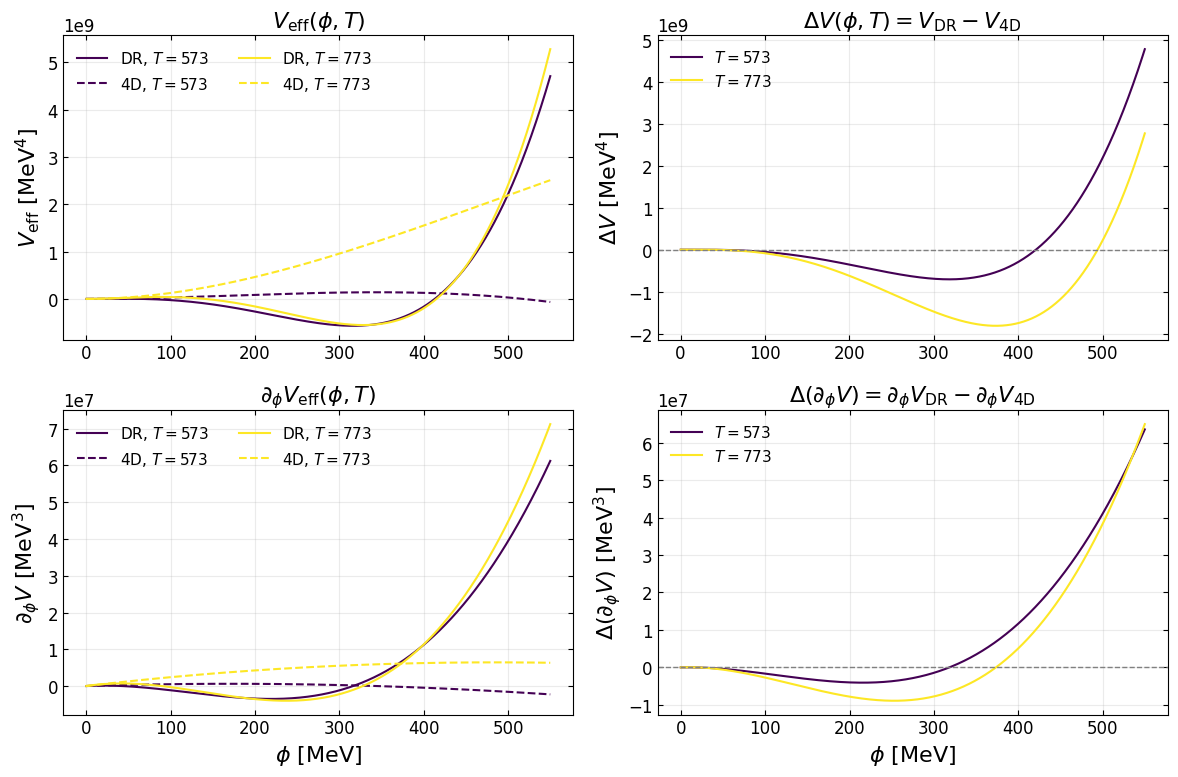

In [ ]:

vev=500
phi = np.linspace(0, 1.1*vev, 2601)
phi = phi.reshape(-1,1)
Ts  = np.random.uniform(0, 3*vev, size=2)
Ts = np.round(Ts).astype(int)
compare_DR_vs_4D_multi(phi, Ts)


In [ ]:
import numpy as np
import itertools
import pandas as pd

from potential_3d import V as V_DR
from veff_4d import V as V_4D
import potential_3d as dr
import veff_4d as v4

# -----------------------------
# Your DR/4D helper functions
# -----------------------------
def set_4d_params(g4, lam4, m0sq4, Yphi=1.0, nA=2.0):
    v4.g4    = float(g4)
    v4.lam4  = float(lam4)
    v4.m0sq4 = float(m0sq4)
    v4.Yphi  = float(Yphi)
    if hasattr(v4, "n_A"):
        v4.n_A = float(nA)

def Lb(mu, T):
    return 2*np.euler_gamma - 2*np.log(4*np.pi) + np.log((mu**2)/(T**2))

def g3sq_of_mu(mu, T, g4, Yphi):
    L = Lb(mu, T)
    return g4**2 * T - (g4**4 * L * T * Yphi**2)/(48.0*np.pi**2)

def lam3_of_mu(mu, T, g4, lam4, Yphi):
    L = Lb(mu, T)
    num = (g4**4 * (2.0 - 3.0*L) * Yphi**4
           + 6.0*g4**2 * L * Yphi**2 * lam4
           + 2.0*lam4*(8.0*np.pi**2 - 5.0*L*lam4))
    return T * num / (16.0*np.pi**2)

def beta_m3sq(mu, T, g4, lam4, Yphi):
    g3sq = g3sq_of_mu(mu, T, g4, Yphi)
    lam3 = lam3_of_mu(mu, T, g4, lam4, Yphi)
    return (g3sq**2 * Yphi**4 - 2.0*g3sq*Yphi**2*lam3 + 2.0*lam3**2) / (4.0*np.pi**2)

def integrate_m3sq(mu_from, mu_to, m3sq_from, T, g4, lam4, Yphi, nsteps=220):
    mu_from = float(mu_from); mu_to = float(mu_to)
    l0, l1 = np.log(mu_from), np.log(mu_to)
    ln_grid = np.linspace(l0, l1, nsteps + 1)

    m = float(m3sq_from)
    for i in range(nsteps):
        dln = ln_grid[i+1] - ln_grid[i]
        mu_i  = np.exp(ln_grid[i])
        mu_h  = np.exp(ln_grid[i] + 0.5*dln)
        mu_ip = np.exp(ln_grid[i+1])

        k1 = beta_m3sq(mu_i,  T, g4, lam4, Yphi)
        k2 = beta_m3sq(mu_h,  T, g4, lam4, Yphi)
        k3 = beta_m3sq(mu_h,  T, g4, lam4, Yphi)
        k4 = beta_m3sq(mu_ip, T, g4, lam4, Yphi)

        m = m + (dln/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return m

def set_dr_get_params_mu_dependent(T, g4, lam4, m0sq4, mu3US, Yphi=1.0, mu_match=None):
    T = float(T)
    mu3US = float(mu3US)
    if mu_match is None:
        mu_match = g4 * T  # Replacing 2*np.pi*T with gT
    mu_match = float(mu_match)

    # placeholder matching at mu_match (keep or replace with your real matching)
    m3sq_match = m0sq4 + (0.30*(g4**2) + 0.10*lam4) * T*T

    g3sq = g3sq_of_mu(mu3US, T, g4, Yphi)
    lam3 = lam3_of_mu(mu3US, T, g4, lam4, Yphi)
    m3sq = integrate_m3sq(mu_match, mu3US, m3sq_match, T, g4, lam4, Yphi)

    g1_3 = np.sqrt(max(g3sq, 0.0))

    def _gp(_T):
        return dict(Yphi=float(Yphi), g1=float(g1_3), lam=float(lam3), msq=float(m3sq), mu3US=float(mu3US))
    dr.get_params = _gp

def V_DR_as_4D(phi4, T):
    T = float(T)
    phi4 = np.asarray(phi4, dtype=float)
    phi3 = phi4 / np.sqrt(T)
    return T * V_DR(phi3, T)

def normalize_to_zero_at_origin(Vvals):
    # assumes first point is ~origin
    return Vvals - Vvals[0]

# -----------------------------
# Generic scan engine
# -----------------------------
def param_grid(spec: dict):
    """
    spec example:
      spec = {
        "g4": [0.5, 0.6],
        "lam4": [1e-3, 2e-3],
        "m0sq4": [-(130.0**2)],
        "Yphi": [1.0],
        "nA": [2.0],
        "v": [500.0],
        "T_over_v": [0.39, 0.01],
      }
    """
    keys = list(spec.keys())
    vals = [spec[k] if isinstance(spec[k], (list, tuple, np.ndarray)) else [spec[k]] for k in keys]
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

def run_scan(
    spec,
    *,
    x_max_map=None,              # dict: {T_over_v: xmax} or callable(T_over_v)->xmax
    Nphi=1200,
    phi_eps_over_v=1e-6,
    mu_match_factor=g4,           # Changed to g4*T instead of 2*np.pi*T
    mu_band_factors=(1, 2, 4),    # Now in terms of gT, so factors are scaled by gT
    mu_central="gT",             # central curve mu3=gT or number* T
    out_prefix="scan_results",
):
    """
    Produces:
      - out_prefix + ".npz": full curves
      - out_prefix + ".csv": summary metrics per point
    """
    orig_gp = dr.get_params
    all_rows = []
    curves = []  # store dict per point with arrays

    def get_xmax(r):
        if x_max_map is None:
            return 2.6 if r > 0.1 else 0.02
        if callable(x_max_map):
            return float(x_max_map(r))
        return float(x_max_map.get(r, 2.6))

    for p in param_grid(spec):
        g4   = float(p["g4"])
        lam4 = float(p["lam4"])
        m0sq4= float(p["m0sq4"])
        Yphi = float(p.get("Yphi", 1.0))
        nA   = float(p.get("nA", 2.0))
        v    = float(p.get("v", 500.0))
        rTv  = float(p["T_over_v"])
        T    = rTv * v
        xmax = get_xmax(rTv)

        set_4d_params(g4, lam4, m0sq4, Yphi=Yphi, nA=nA)

        x = np.linspace(phi_eps_over_v, xmax, Nphi)  # phi/v
        phi4 = x * v

        # 4D curve
        V4 = V_4D(phi4, T)
        V4 = normalize_to_zero_at_origin(V4) / (v**4)

        # DR central mu
        mu_match = mu_match_factor * T  # Replacing 2*np.pi*T with gT
        if mu_central == "gT":
            mu_c = g4 * T
        else:
            mu_c = float(mu_central) * T

        set_dr_get_params_mu_dependent(T, g4, lam4, m0sq4, mu_c, Yphi=Yphi, mu_match=mu_match)
        Vc = V_DR_as_4D(phi4, T)
        Vc = normalize_to_zero_at_origin(Vc) / (v**4)

        # DR band scan
        Vband = []
        for f in mu_band_factors:
            mu_i = f * g4 * T  # Scaled by gT
            set_dr_get_params_mu_dependent(T, g4, lam4, m0sq4, mu_i, Yphi=Yphi, mu_match=mu_match)
            Vi = V_DR_as_4D(phi4, T)
            Vi = normalize_to_zero_at_origin(Vi) / (v**4)
            Vband.append(Vi)
        Vband = np.asarray(Vband)
        Vmin = np.nanmin(Vband, axis=0)
        Vmax = np.nanmax(Vband, axis=0)

        # simple metrics
        max_abs_diff = float(np.nanmax(np.abs(Vc - V4)))
        inside = (V4 >= Vmin) & (V4 <= Vmax)
        frac_inside = float(np.mean(inside))
        band_width_max = float(np.nanmax(Vmax - Vmin))
        band_width_mean = float(np.nanmean(Vmax - Vmin))

        row = dict(
            **{k: float(p[k]) for k in p},
            T=float(T),
            xmax=float(xmax),
            mu_match=float(mu_match),
            mu_c=float(mu_c),
            max_abs_diff=max_abs_diff,
            frac_inside=frac_inside,
            band_width_max=band_width_max,
            band_width_mean=band_width_mean,
        )
        all_rows.append(row)

        curves.append(dict(
            params=row,
            x=x,
            V4=V4,
            Vc=Vc,
            Vmin=Vmin,
            Vmax=Vmax,
            mu_band_factors=np.array(mu_band_factors, dtype=float),
        ))

    # restore
    dr.get_params = orig_gp

    # save summary
    df = pd.DataFrame(all_rows)
    df.to_csv(f"{out_prefix}.csv", index=False)

    # save curves (npz; store list as object array)
    np.savez_compressed(
        f"{out_prefix}.npz",
        curves=np.array(curves, dtype=object),
    )
    return df

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    spec = {
        "g4": [0.50, 0.54, 0.58],
        "lam4": [1.2e-3, 1.65e-3, 2.2e-3],
        "m0sq4": [-(130.0**2)],
        "Yphi": [1.0],
        "nA": [2.0],
        "v": [500.0],
        "T_over_v": [0.39, 0.01],
    }

    df = run_scan(
        spec,
        mu_band_factors=(1, 2, 4),  # in terms of gT
        mu_central="gT",            # central curve (gT)
        out_prefix="my_param_scan",
    )
    print(df.sort_values(["max_abs_diff"]).head(10))


      g4     lam4    m0sq4  Yphi   nA      v  T_over_v      T  xmax  mu_match  \
1   0.50  0.00120 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
3   0.50  0.00165 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
5   0.50  0.00220 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
7   0.54  0.00120 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
9   0.54  0.00165 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
11  0.54  0.00220 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
13  0.58  0.00120 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
15  0.58  0.00165 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
17  0.58  0.00220 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
4   0.50  0.00220 -16900.0   1.0  2.0  500.0      0.39  195.0  2.60     105.3   

    mu_c  max_abs_diff  frac_inside  band_width_max  band_width_mean  
1    2.5  4.019218e-09     0.000833  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

def _as_dict(obj):
    # element can be dict already, or a 0-d object array containing dict
    if isinstance(obj, np.ndarray):
        return obj.item()
    return obj

def plot_scan_multipanel_by_Tv(
    npz_file,
    *,
    max_panels_per_group=12,
    ncols=4,
    group_tol=1e-6,
    scales_by_Tv=None,                 # e.g. {0.01: 1e10}
    sort_within_group="max_abs_diff",  # params key or None
    sort_desc=True,
    fig_width_per_col=3.6,
    fig_height_per_row=3.0,
    show_legend=False,                 # per-panel legend
    global_legend=True,                # one legend for whole figure
    param_box=True,                    # put params inside axes
    param_fontsize=7.0,
    param_loc="lower left",            # "lower left" or "upper left"
    title_mode="group",                # "group" or "none"
    save=None,                         # "out.png" -> saves one file per Tv group
    show=True,
):
    data = np.load(npz_file, allow_pickle=True)
    curves = data["curves"]

    # ---- group by T/v with rounding to avoid float jitter
    groups = defaultdict(list)
    for i in range(len(curves)):
        c = _as_dict(curves[i])
        p = c["params"]
        Tv = float(p["T"]) / float(p["v"])
        Tv_key = round(Tv / group_tol) * group_tol
        groups[Tv_key].append((i, c))

    Tv_keys = sorted(groups.keys())
    figs = []

    # helper: choose scale for this Tv group
    def _scale_for_Tv(Tv_key):
        if not scales_by_Tv:
            return 1.0
        nearest = min(scales_by_Tv.keys(), key=lambda k: abs(float(k) - float(Tv_key)))
        if abs(float(nearest) - float(Tv_key)) < 10 * group_tol:
            return float(scales_by_Tv[nearest])
        return 1.0

    # helper: inside-panel text placement
    def _param_anchor(loc):
        if loc == "upper left":
            return (0.03, 0.97, "top", "left")
        # default lower left
        return (0.03, 0.05, "bottom", "left")

    for Tv_key in Tv_keys:
        items = groups[Tv_key]

        # sort within group
        if sort_within_group is not None:
            items = sorted(
                items,
                key=lambda t: _as_dict(t[1])["params"].get(sort_within_group, 0.0),
                reverse=bool(sort_desc),
            )

        items = items[:max_panels_per_group]
        n = len(items)
        nrows = math.ceil(n / ncols)

        fig_w = fig_width_per_col * ncols
        fig_h = fig_height_per_row * nrows

        fig, axs = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), constrained_layout=True)
        axs = np.atleast_1d(axs).ravel()

        scale = _scale_for_Tv(Tv_key)

        for ax_i, ax in enumerate(axs):
            if ax_i >= n:
                ax.axis("off")
                continue

            idx, c = items[ax_i]
            p = c["params"]

            x    = c["x"]
            V4   = c["V4"]   * scale
            Vc   = c["Vc"]   * scale
            Vmin = c["Vmin"] * scale
            Vmax = c["Vmax"] * scale

            # plots
            ax.fill_between(x, Vmin, Vmax, alpha=0.25, label="DR band")
            ax.plot(x, Vc, "-",  label="DR central")
            ax.plot(x, V4, "--", label="4D(HT)")

            # labels
            ax.set_xlabel(r"$\phi/v$")
            ylab = r"$V(\phi)/v^4$" + (r"$\,[10^{-10}]$" if scale != 1.0 else "")
            ax.set_ylabel(ylab)
            ax.grid(alpha=0.25)

            #  title
            ax.set_title(f"#{idx}", fontsize=10)

            # parameters INSIDE the panel
            if param_box:
                param_text = (
                    rf"$g_4={p['g4']:.2f}$" "\n"
                    rf"$\lambda_4={p['lam4']:.2e}$" "\n"
                    rf"$\max|\Delta|={p.get('max_abs_diff', float('nan')):.2e}$"
                )
                x0, y0, va, ha = _param_anchor(param_loc)
                ax.text(
                    x0, y0, param_text,
                    transform=ax.transAxes,
                    fontsize=float(param_fontsize),
                    va=va, ha=ha,
                    bbox=dict(
                        boxstyle="round,pad=0.2",
                        facecolor="white",
                        alpha=0.75,
                        edgecolor="none",
                    )
                )

            if show_legend:
                ax.legend(loc="best")

        # global legend (once per figure)
        if global_legend:
            handles, labels = axs[0].get_legend_handles_labels()
            fig.legend(handles, labels, ncols=3, loc="upper center", bbox_to_anchor=(0.5, 1.02))

        if title_mode == "group":
            fig.suptitle(rf"$T/v={Tv_key:.6g}$ (scale={scale:g})", y=1.06)

        figs.append(fig)

        # save one file per Tv group if requested
        if save:
            base, ext = (save.rsplit(".", 1) + ["png"])[:2]
            out = f"{base}_Tv_{Tv_key:.6g}.{ext}"
            fig.savefig(out, bbox_inches="tight", dpi=300)

        if show:
            plt.show()
        else:
            plt.close(fig)

    return figs


# ---- example call ----
# plot_scan_multipanel_by_Tv(
#     "my_param_scan.npz",
#     max_panels_per_group=12,
#     ncols=4,
#     scales_by_Tv={0.01: 1e10},
#     sort_within_group="max_abs_diff",
#     param_box=True,
#     param_fontsize=7.0,
#     param_loc="lower left",
#     save="multipanel.png",
# )


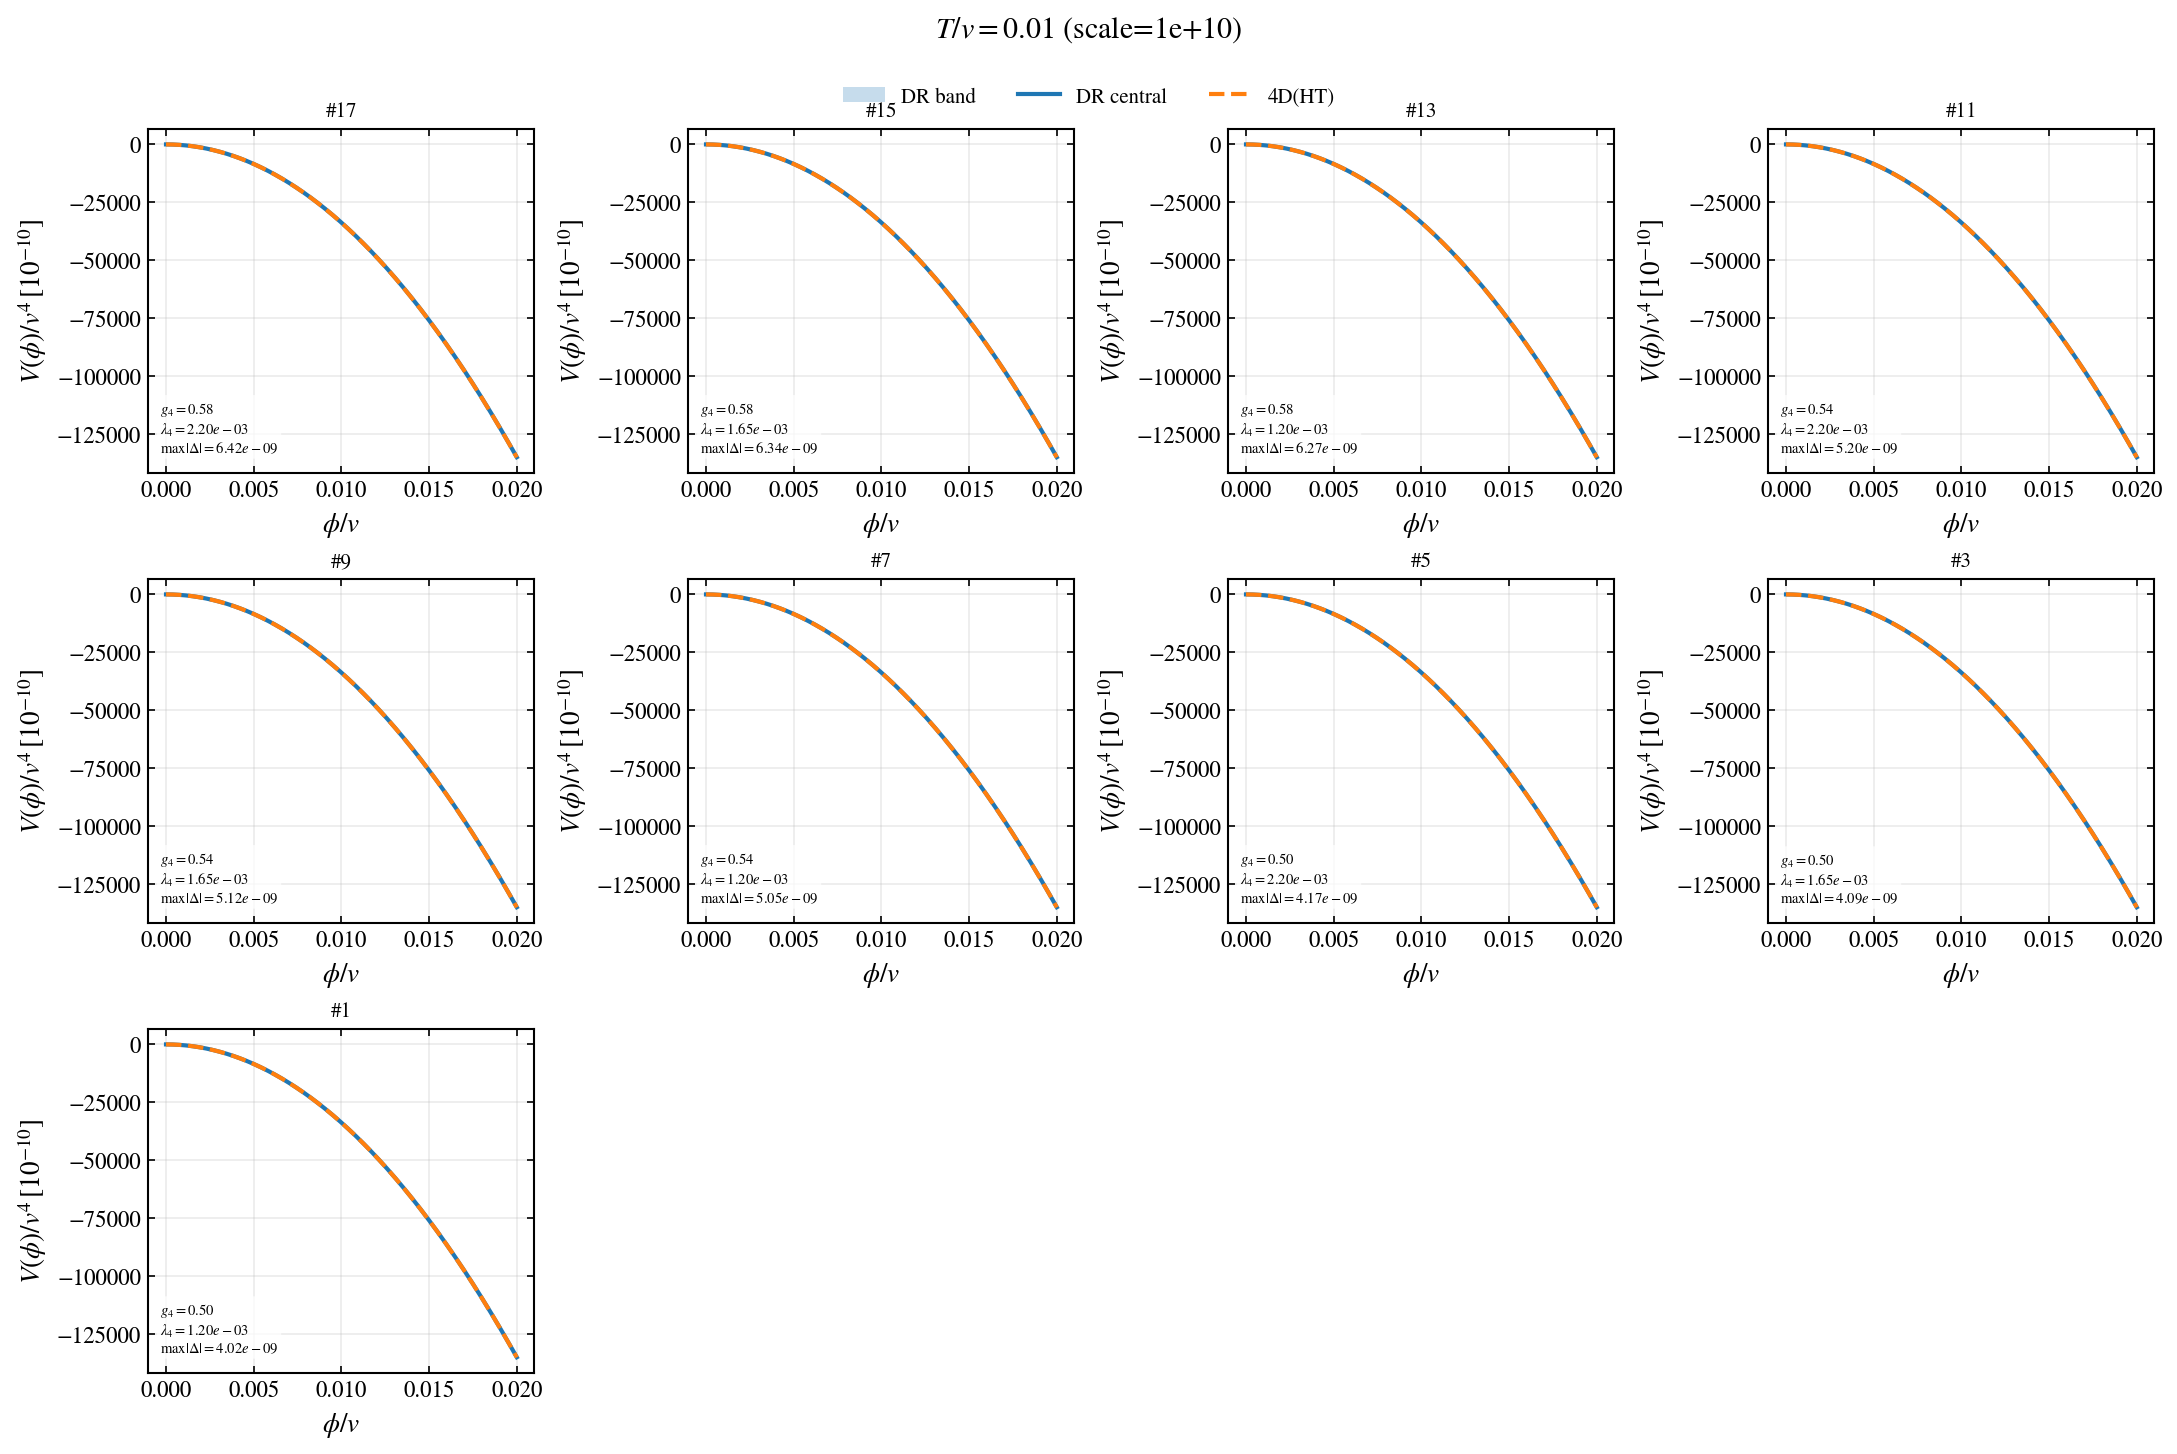

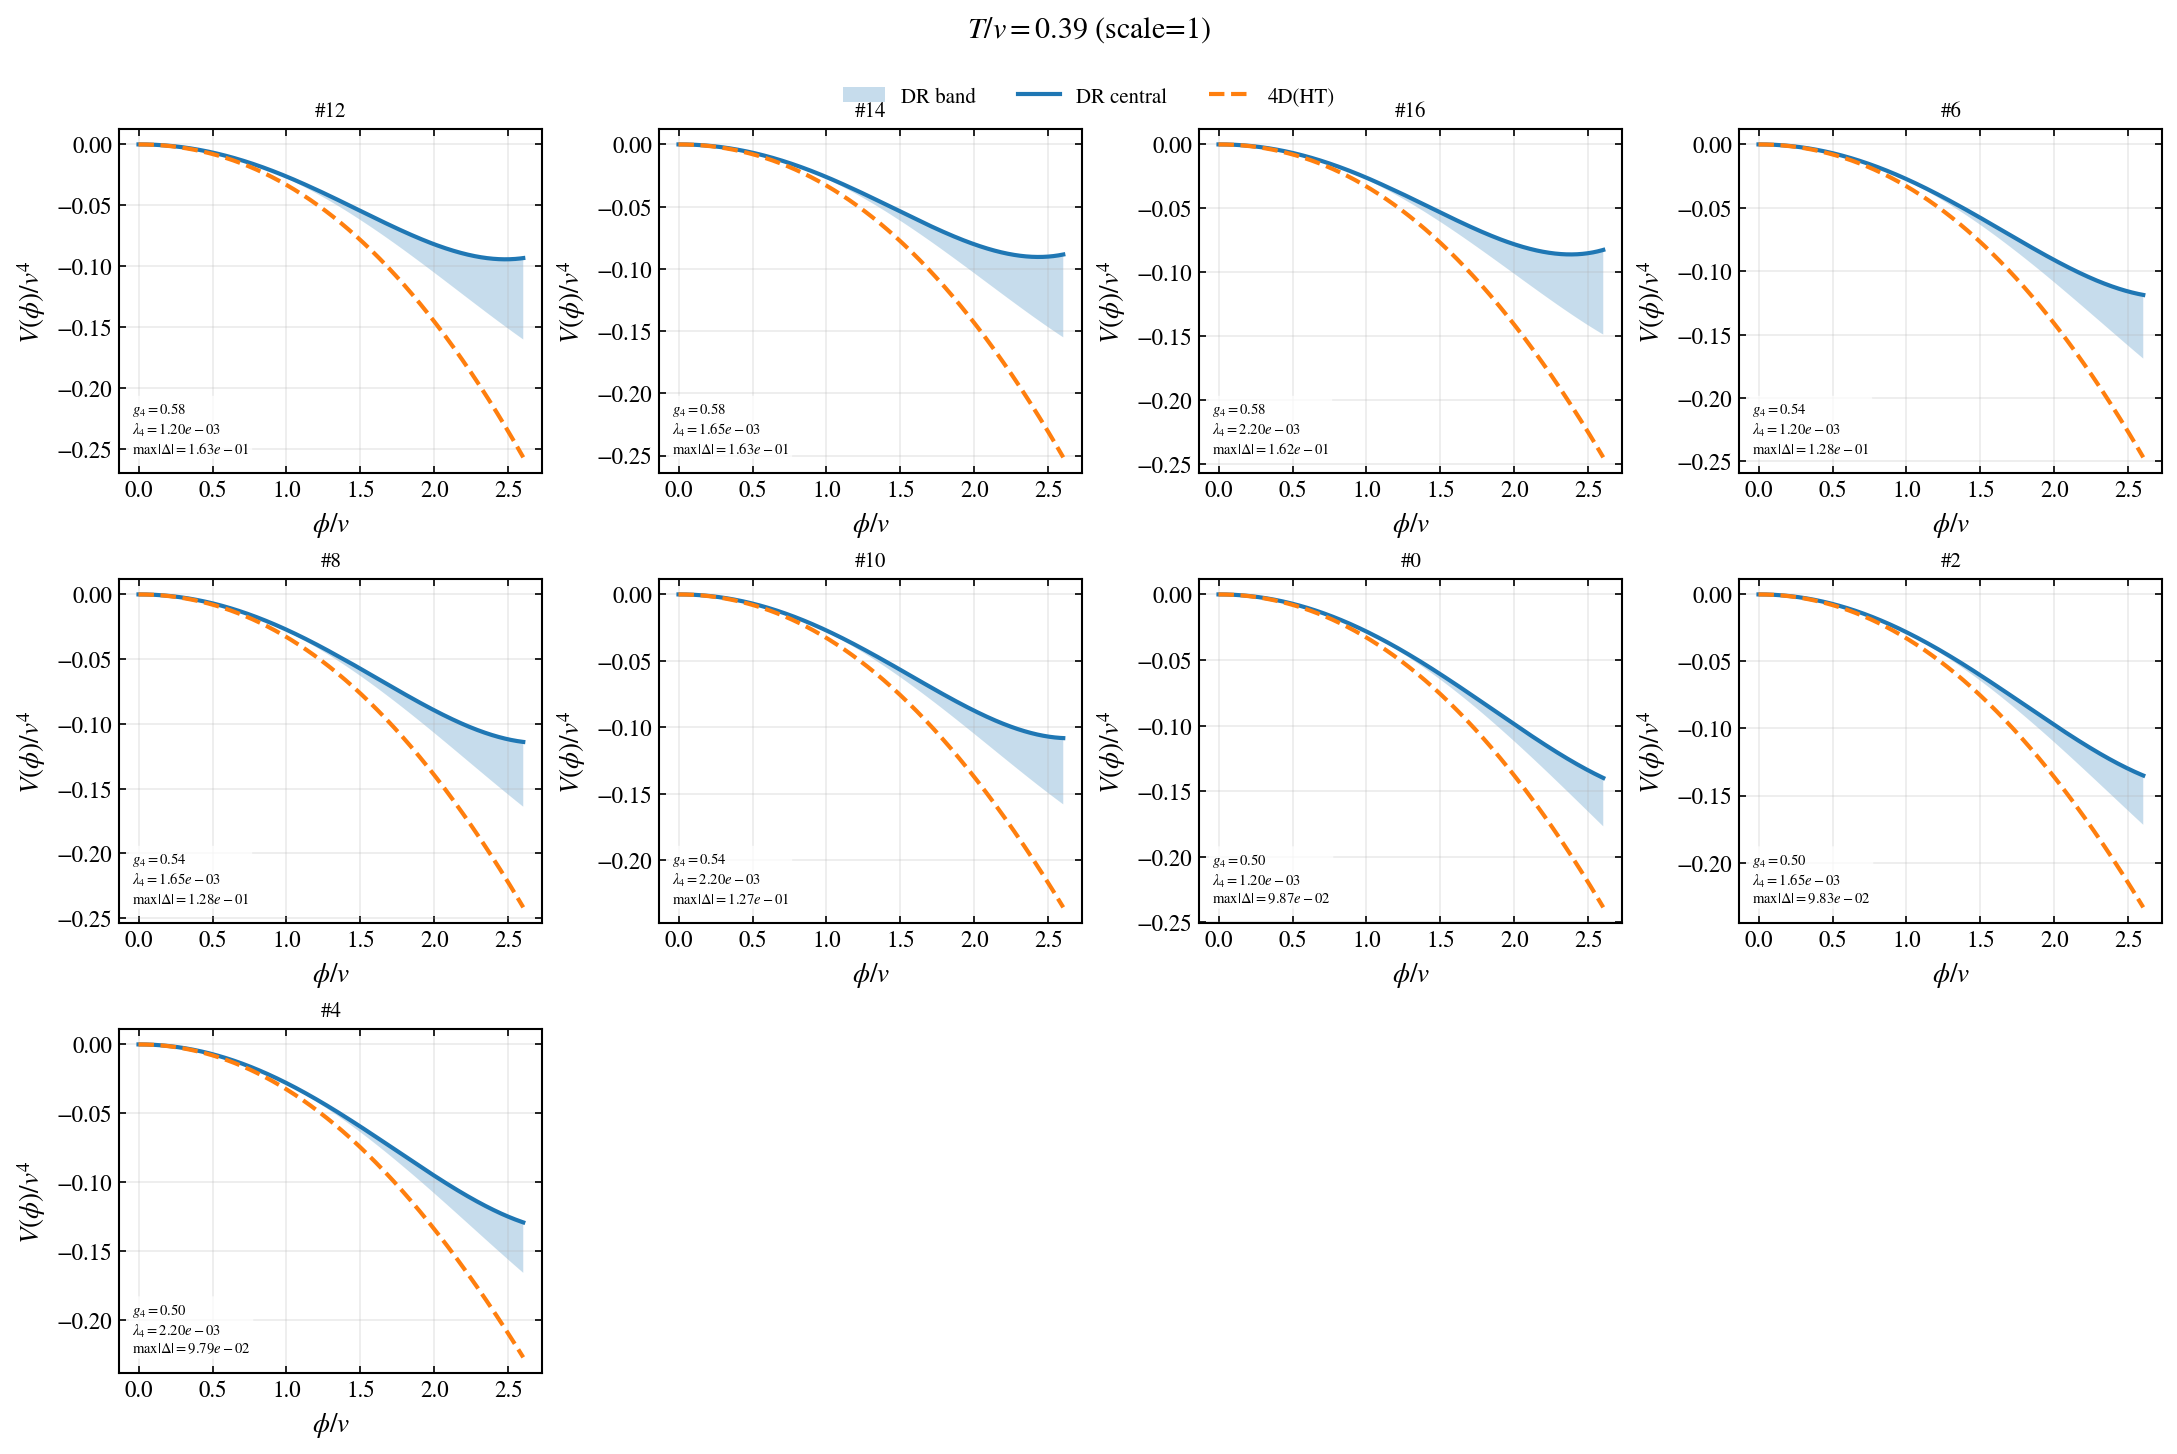

[<Figure size 2160x1350 with 12 Axes>, <Figure size 2160x1350 with 12 Axes>]

In [ ]:
plot_scan_multipanel_by_Tv(
    "my_param_scan.npz",
    max_panels_per_group=12,
    ncols=4,
    scales_by_Tv={0.01: 1e10},      # auto-rescale low T/v group
    sort_within_group="max_abs_diff",
    save="multipanel.png",          # will save one file per T/v group
)


In [ ]:
 %%writefile veff_4d_full.py
"""
veff_4d_full.py
4D one-loop finite-T potential in high-T expansion up to m^4 log
+ daisy (ring) resummation for bosonic zero modes.

Landau gauge. Abelian Higgs: (H,G) + U(1) gauge (T,L).
"""

import numpy as np

# --------- default 4D inputs (you can overwrite from outside) ----------
g4    = 0.54
lam4  = 1.65e-3
m0sq4 = -(130.0**2)
Yphi  = 1.0

# DOF split (more physical than n_A=3 lumped)
n_h = 1.0
n_G = 1.0
n_T = 2.0   # transverse gauge
n_L = 1.0   # longitudinal gauge

# MSbar constants in CW
c_s = 1.5
c_v = 5.0/6.0

# thermal constant in HT log term: a_b = 16π^2 exp(3/2 - 2γ_E)
a_b = 16.0*np.pi**2 * np.exp(1.5 - 2.0*np.euler_gamma)

def _clip_pos(x, floor=1e-30):
    x = np.asarray(x, dtype=float)
    return np.maximum(x, floor)

def _m_abs(m2):
    # keep potential real for tachyonic regions (same spirit as your DR code)
    return np.sqrt(np.abs(np.asarray(m2, dtype=float)))

# ---------- tree-level masses ----------
def m_h2(phi):
    return m0sq4 + 3.0*lam4*phi*phi

def m_G2(phi):
    return m0sq4 + 1.0*lam4*phi*phi

def m_A2(phi):
    return (g4*Yphi)**2 * phi*phi

# ---------- tree-level potential ----------
def V_tree(phi):
    return 0.5*m0sq4*phi*phi + 0.25*lam4*(phi**4)

# ---------- CW (T=0) one-loop ----------
def V_CW(m2, n, mu4, c):
    m2 = np.asarray(m2, dtype=float)
    mu4 = float(mu4)
    # use |m2| to stay real; log uses |m2|
    m2a = np.abs(m2)
    return n * (m2a*m2a) * (np.log(_clip_pos(m2a)/(mu4*mu4)) - c) / (64.0*np.pi**2)

# ---------- high-T thermal (to m^4 log) ----------
def V_T_HT(m2, n, T):
    """
    From J_b expansion:
    ΔV_T = n * [  m^2 T^2/24  -  m^3 T/(12π)  -  m^4/(64π^2) ln(m^2/(a_b T^2))  ]
    Drop φ-independent -π^2 T^4/90.
    """
    T = float(T)
    m2 = np.asarray(m2, dtype=float)
    m  = _m_abs(m2)
    term_T2 = (m2 * T*T) / 24.0
    term_T3 = -(m**3 * T) / (12.0*np.pi)
    term_T4log = -(m2*m2) * np.log(_clip_pos(np.abs(m2))/(a_b*T*T)) / (64.0*np.pi**2)
    return n * (term_T2 + term_T3 + term_T4log)

# ---------- daisy / ring resummation ----------
def thermal_masses(T):
    """
    LO thermal masses for Abelian Higgs (one complex scalar):
      Π_scalar ≈ (λ/3 + g^2 Y^2/4) T^2
      m_D^2 (U(1) Debye) ≈ (g^2 Y^2/3) T^2   (one complex scalar)
    """
    T = float(T)
    Pi_s = (lam4/3.0 + (g4*g4*Yphi*Yphi)/4.0) * T*T
    mD2  = ((g4*g4*Yphi*Yphi)/3.0) * T*T
    return Pi_s, mD2

def V_ring(phi, T):
    """
    Add ring correction for bosonic zero modes that get Π(T):
      -T/(12π) Σ [ (M^2)^{3/2} - (m^2)^{3/2} ]
    We apply to: Higgs, Goldstone, gauge-longitudinal.
    """
    T = float(T)
    phi = np.asarray(phi, dtype=float)

    Pi_s, mD2 = thermal_masses(T)

    mh2 = m_h2(phi); MG2 = m_G2(phi); mA2 = m_A2(phi)

    Mh = _m_abs(mh2 + Pi_s)
    MG = _m_abs(MG2 + Pi_s)
    ML = _m_abs(mA2 + mD2)

    mh = _m_abs(mh2)
    mG = _m_abs(MG2)
    mA = _m_abs(mA2)

    return -(T/(12.0*np.pi)) * (
        n_h*(Mh**3 - mh**3) +
        n_G*(MG**3 - mG**3) +
        n_L*(ML**3 - mA**3)
    )

def V(phi, T, mu4=None, include_CW=True, include_ring=True):
    """
    Full 4D potential (in the HT-expanded thermal part) with daisy.
    Default choice: mu4 = π T (common for HT comparisons).
    """
    phi = np.asarray(phi, dtype=float)
    T = float(T)
    if mu4 is None:
        mu4 = np.pi*T if T > 0 else 1.0

    V0 = V_tree(phi)

    mh2 = m_h2(phi); mG2 = m_G2(phi); mA2 = m_A2(phi)

    # thermal HT (split gauge into T and L)
    VT = (
        V_T_HT(mh2, n_h, T) +
        V_T_HT(mG2, n_G, T) +
        V_T_HT(mA2, n_T, T) +
        V_T_HT(mA2, n_L, T)
    )

    VCW = 0.0
    if include_CW:
        VCW = (
            V_CW(mh2, n_h, mu4, c_s) +
            V_CW(mG2, n_G, mu4, c_s) +
            V_CW(mA2, n_T+n_L, mu4, c_v)
        )

    VR = 0.0
    if include_ring and T > 0:
        VR = V_ring(phi, T)

    return V0 + VCW + VT + VR

def dV(phi, T):
    phi = np.asarray(phi, dtype=float)
    T = float(T)
    h = 1e-3*np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi+h, T) - V(phi-h, T)) / (2.0*h)


Overwriting veff_4d_full.py


In [ ]:
import numpy as np
import itertools
import pandas as pd

from potential_3d import V as V_DR
import potential_3d as dr

from veff_4d_full import V as V_4D
import veff_4d_full as v4

mpl.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 600,
    "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 13,
    "legend.fontsize": 10, "xtick.labelsize": 11, "ytick.labelsize": 11,
    "axes.linewidth": 1.0, "lines.linewidth": 2.0,
    "legend.frameon": False,
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.top": True, "ytick.right": True,
    "mathtext.fontset": "stix", "font.family": "STIXGeneral",
})

# Modify set_4d_params to accept nA as an argument
def set_4d_params(g4, lam4, m0sq4, Yphi=1.0, nA=None):
    v4.g4    = float(g4)
    v4.lam4  = float(lam4)
    v4.m0sq4 = float(m0sq4)
    v4.Yphi  = float(Yphi)
    if nA is not None:  # Check if nA is provided
        v4.n_A = float(nA)  # Assign nA to v4.n_A if provided

# --- Same running functions ---
def Lb(mu, T):
    return 2*np.euler_gamma - 2*np.log(4*np.pi) + np.log((mu**2)/(T**2))

def g3sq_of_mu(mu, T, g4, Yphi):
    L = Lb(mu, T)
    return g4**2 * T - (g4**4 * L * T * Yphi**2)/(48.0*np.pi**2)

def lam3_of_mu(mu, T, g4, lam4, Yphi):
    L = Lb(mu, T)
    num = (g4**4 * (2.0 - 3.0*L) * Yphi**4
           + 6.0*g4**2 * L * Yphi**2 * lam4
           + 2.0*lam4*(8.0*np.pi**2 - 5.0*L*lam4))
    return T * num / (16.0*np.pi**2)

def beta_m3sq(mu, T, g4, lam4, Yphi):
    g3sq = g3sq_of_mu(mu, T, g4, Yphi)
    lam3 = lam3_of_mu(mu, T, g4, lam4, Yphi)
    return (g3sq**2 * Yphi**4 - 2.0*g3sq*Yphi**2*lam3 + 2.0*lam3**2) / (4.0*np.pi**2)

def integrate_m3sq(mu_from, mu_to, m3sq_from, T, g4, lam4, Yphi, nsteps=220):
    l0, l1 = np.log(mu_from), np.log(mu_to)
    ln_grid = np.linspace(l0, l1, nsteps + 1)
    m = float(m3sq_from)
    for i in range(nsteps):
        dln = ln_grid[i+1] - ln_grid[i]
        mu_i  = np.exp(ln_grid[i])
        mu_h  = np.exp(ln_grid[i] + 0.5*dln)
        mu_ip = np.exp(ln_grid[i+1])
        k1 = beta_m3sq(mu_i,  T, g4, lam4, Yphi)
        k2 = beta_m3sq(mu_h,  T, g4, lam4, Yphi)
        k3 = beta_m3sq(mu_h,  T, g4, lam4, Yphi)
        k4 = beta_m3sq(mu_ip, T, g4, lam4, Yphi)
        m = m + (dln/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return m

def set_dr_get_params_mu_dependent(T, g4, lam4, m0sq4, mu3US, Yphi=1.0, mu_match=None):
    """
     LO matching :
      g3^2 ≈ g^2 T
      λ3   ≈ λ T
      m3^2(μ_match) ≈ m0^2 + Π(T), with Π ≈ (λ/3 + g^2 Y^2/4) T^2
    then run to μ3US with your beta_m3sq.
    """
    T = float(T)
    mu3US = float(mu3US)
    mu_match = float(g4 * T if mu_match is None else mu_match)

    Pi = (lam4/3.0 + (g4*g4*Yphi*Yphi)/4.0) * T*T
    m3sq_match = m0sq4 + Pi

    g3sq = g3sq_of_mu(mu3US, T, g4, Yphi)
    lam3 = lam3_of_mu(mu3US, T, g4, lam4, Yphi)
    m3sq = integrate_m3sq(mu_match, mu3US, m3sq_match, T, g4, lam4, Yphi)

    g1_3 = np.sqrt(max(g3sq, 0.0))

    def _gp(_T):
        return dict(Yphi=float(Yphi), g1=float(g1_3), lam=float(lam3), msq=float(m3sq), mu3US=float(mu3US))
    dr.get_params = _gp

def V_DR_as_4D(phi4, T):
    # physics mapping: phi4 = sqrt(T) phi3  and  V4D ≈ T V3D
    T = float(T)
    phi4 = np.asarray(phi4, dtype=float)
    phi3 = phi4 / np.sqrt(T)
    return T * V_DR(phi3, T)

def normalize_to_zero_at_origin(Vvals):
    # assumes first point is ~origin
    return Vvals - Vvals[0]

# -----------------------------
# Generic scan engine
# -----------------------------
def param_grid(spec: dict):
    """
    spec example:
      spec = {
        "g4": [0.5, 0.6],
        "lam4": [1e-3, 2e-3],
        "m0sq4": [-(130.0**2)],
        "Yphi": [1.0],
        "nA": [2.0],
        "v": [500.0],
        "T_over_v": [0.39, 0.01],
      }
    """
    keys = list(spec.keys())
    vals = [spec[k] if isinstance(spec[k], (list, tuple, np.ndarray)) else [spec[k]] for k in keys]
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

def run_scan(
    spec,
    *,
    x_max_map=None,              # dict: {T_over_v: xmax} or callable(T_over_v)->xmax
    Nphi=1200,
    phi_eps_over_v=1e-6,
    mu_match_factor="gT",        # Define match as gT directly
    mu_band_factors=(1, 2, 4),    # Scaling factors of gT
    mu_central="gT",             # central curve mu3=gT or number* T
    out_prefix="scan_results",
):
    """
    Produces:
      - out_prefix + ".npz": full curves
      - out_prefix + ".csv": summary metrics per point
    """
    orig_gp = dr.get_params
    all_rows = []
    curves = []  # store dict per point with arrays

    def get_xmax(r):
        if x_max_map is None:
            return 2.6 if r > 0.1 else 0.02
        if callable(x_max_map):
            return float(x_max_map(r))
        return float(x_max_map.get(r, 2.6))

    for p in param_grid(spec):
        g4   = float(p["g4"])
        lam4 = float(p["lam4"])
        m0sq4= float(p["m0sq4"])
        Yphi = float(p.get("Yphi", 1.0))
        nA   = float(p.get("nA", 2.0))
        v    = float(p.get("v", 500.0))
        rTv  = float(p["T_over_v"])
        T    = rTv * v
        xmax = get_xmax(rTv)

        set_4d_params(g4, lam4, m0sq4, Yphi=Yphi, nA=nA)

        x = np.linspace(phi_eps_over_v, xmax, Nphi)  # phi/v
        phi4 = x * v

        # 4D curve
        V4 = V_4D(phi4, T)
        V4 = normalize_to_zero_at_origin(V4) / (v**4)

        # DR central mu
        mu_match = float(g4 * T) if mu_match_factor == "gT" else float(mu_match_factor) * T
        if mu_central == "gT":
            mu_c = g4 * T
        else:
            mu_c = float(mu_central) * T

        set_dr_get_params_mu_dependent(T, g4, lam4, m0sq4, mu_c, Yphi=Yphi, mu_match=mu_match)
        Vc = V_DR_as_4D(phi4, T)
        Vc = normalize_to_zero_at_origin(Vc) / (v**4)

        # DR band scan
        Vband = []
        for f in mu_band_factors:
            mu_i = float(f) * g4 * T  # Scaled by gT
            set_dr_get_params_mu_dependent(T, g4, lam4, m0sq4, mu_i, Yphi=Yphi, mu_match=mu_match)
            Vi = V_DR_as_4D(phi4, T)
            Vi = normalize_to_zero_at_origin(Vi) / (v**4)
            Vband.append(Vi)
        Vband = np.asarray(Vband)
        Vmin = np.nanmin(Vband, axis=0)
        Vmax = np.nanmax(Vband, axis=0)

        # simple metrics
        max_abs_diff = float(np.nanmax(np.abs(Vc - V4)))
        inside = (V4 >= Vmin) & (V4 <= Vmax)
        frac_inside = float(np.mean(inside))
        band_width_max = float(np.nanmax(Vmax - Vmin))
        band_width_mean = float(np.nanmean(Vmax - Vmin))

        row = dict(
            **{k: float(p[k]) for k in p},
            T=float(T),
            xmax=float(xmax),
            mu_match=float(mu_match),
            mu_c=float(mu_c),
            max_abs_diff=max_abs_diff,
            frac_inside=frac_inside,
            band_width_max=band_width_max,
            band_width_mean=band_width_mean,
        )
        all_rows.append(row)

        curves.append(dict(
            params=row,
            x=x,
            V4=V4,
            Vc=Vc,
            Vmin=Vmin,
            Vmax=Vmax,
            mu_band_factors=np.array(mu_band_factors, dtype=float),
        ))

    # restore
    dr.get_params = orig_gp

    # save summary
    df = pd.DataFrame(all_rows)
    df.to_csv(f"{out_prefix}.csv", index=False)

    # save curves (npz; store list as object array)
    np.savez_compressed(
        f"{out_prefix}.npz",
        curves=np.array(curves, dtype=object),
    )
    return df

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    spec = {
        "g4": [0.50, 0.54, 0.58],
        "lam4": [1.2e-3, 1.65e-3, 2.2e-3],
        "m0sq4": [-(130.0**2)],
        "Yphi": [1.0],
        "nA": [2.0],
        "v": [500.0],
        "T_over_v": [0.39, 0.01],
    }

    df = run_scan(
        spec,
        mu_band_factors=(1, 2, 4),  # in terms of gT
        mu_central="gT",            # central curve (gT)
        out_prefix="my_param_scan2",
    )
    print(df.sort_values(["max_abs_diff"]).head(10))


      g4     lam4    m0sq4  Yphi   nA      v  T_over_v      T  xmax  mu_match  \
1   0.50  0.00120 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.5   
3   0.50  0.00165 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.5   
5   0.50  0.00220 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.5   
7   0.54  0.00120 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
9   0.54  0.00165 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
11  0.54  0.00220 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.7   
13  0.58  0.00120 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.9   
15  0.58  0.00165 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.9   
17  0.58  0.00220 -16900.0   1.0  2.0  500.0      0.01    5.0  0.02       2.9   
4   0.50  0.00220 -16900.0   1.0  2.0  500.0      0.39  195.0  2.60      97.5   

    mu_c  max_abs_diff  frac_inside  band_width_max  band_width_mean  
1    2.5  4.010208e-09     0.000833  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

def _as_dict(obj):
    # element can be dict already, or a 0-d object array containing dict
    if isinstance(obj, np.ndarray):
        return obj.item()
    return obj

def plot_scan_multipanel_by_Tv(
    npz_file,
    *,
    max_panels_per_group=12,
    ncols=4,
    group_tol=1e-6,
    scales_by_Tv=None,                 # e.g. {0.01: 1e10}
    sort_within_group="max_abs_diff",  # params key or None
    sort_desc=True,
    fig_width_per_col=3.6,
    fig_height_per_row=3.0,
    show_legend=False,                 # per-panel legend
    global_legend=True,                # one legend for whole figure
    param_box=True,                    # put params inside axes
    param_fontsize=7.0,
    param_loc="lower left",            # "lower left" or "upper left"
    title_mode="group",                # "group" or "none"
    save=None,                         # "out.png" -> saves one file per Tv group
    show=True,
):
    data = np.load(npz_file, allow_pickle=True)
    curves = data["curves"]

    # ---- group by T/v with rounding to avoid float jitter
    groups = defaultdict(list)
    for i in range(len(curves)):
        c = _as_dict(curves[i])
        p = c["params"]
        Tv = float(p["T"]) / float(p["v"])
        Tv_key = round(Tv / group_tol) * group_tol
        groups[Tv_key].append((i, c))

    Tv_keys = sorted(groups.keys())
    figs = []

    # helper: choose scale for this Tv group
    def _scale_for_Tv(Tv_key):
        if not scales_by_Tv:
            return 1.0
        nearest = min(scales_by_Tv.keys(), key=lambda k: abs(float(k) - float(Tv_key)))
        if abs(float(nearest) - float(Tv_key)) < 10 * group_tol:
            return float(scales_by_Tv[nearest])
        return 1.0

    # helper: inside-panel text placement
    def _param_anchor(loc):
        if loc == "upper left":
            return (0.03, 0.97, "top", "left")
        # default lower left
        return (0.03, 0.05, "bottom", "left")

    for Tv_key in Tv_keys:
        items = groups[Tv_key]

        # sort within group
        if sort_within_group is not None:
            items = sorted(
                items,
                key=lambda t: _as_dict(t[1])["params"].get(sort_within_group, 0.0),
                reverse=bool(sort_desc),
            )

        items = items[:max_panels_per_group]
        n = len(items)
        nrows = math.ceil(n / ncols)

        fig_w = fig_width_per_col * ncols
        fig_h = fig_height_per_row * nrows

        fig, axs = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), constrained_layout=True)
        axs = np.atleast_1d(axs).ravel()

        scale = _scale_for_Tv(Tv_key)

        for ax_i, ax in enumerate(axs):
            if ax_i >= n:
                ax.axis("off")
                continue

            idx, c = items[ax_i]
            p = c["params"]

            x    = c["x"]
            V4   = c["V4"]   * scale
            Vc   = c["Vc"]   * scale
            Vmin = c["Vmin"] * scale
            Vmax = c["Vmax"] * scale

            # plots
            ax.fill_between(x, Vmin, Vmax, alpha=0.25, label="DR band")
            ax.plot(x, Vc, "-",  label="DR central")
            ax.plot(x, V4, "--", label="4D (HT+CW+daisy)")

            # labels
            ax.set_xlabel(r"$\phi/v$")
            ylab = r"$V(\phi)/v^4$" + (r"$\,[10^{-10}]$" if scale != 1.0 else "")
            ax.set_ylabel(ylab)
            ax.grid(alpha=0.25)

            #  title
            ax.set_title(f"#{idx}", fontsize=10)

            # parameters INSIDE the panel
            if param_box:
                param_text = (
                    rf"$g_4={p['g4']:.2f}$" "\n"
                    rf"$\lambda_4={p['lam4']:.2e}$" "\n"
                    rf"$\max|\Delta|={p.get('max_abs_diff', float('nan')):.2e}$"
                )
                x0, y0, va, ha = _param_anchor(param_loc)
                ax.text(
                    x0, y0, param_text,
                    transform=ax.transAxes,
                    fontsize=float(param_fontsize),
                    va=va, ha=ha,
                    bbox=dict(
                        boxstyle="round,pad=0.2",
                        facecolor="white",
                        alpha=0.75,
                        edgecolor="none",
                    )
                )

            if show_legend:
                ax.legend(loc="best")

        # global legend (once per figure)
        if global_legend:
            handles, labels = axs[0].get_legend_handles_labels()
            fig.legend(handles, labels, ncols=3, loc="upper center", bbox_to_anchor=(0.5, 1.02))

        if title_mode == "group":
            fig.suptitle(rf"$T/v={Tv_key:.6g}$ (scale={scale:g})", y=1.06)

        figs.append(fig)

        # save one file per Tv group if requested
        if save:
            base, ext = (save.rsplit(".", 1) + ["png"])[:2]
            out = f"{base}_Tv_{Tv_key:.6g}.{ext}"
            fig.savefig(out, bbox_inches="tight", dpi=300)

        if show:
            plt.show()
        else:
            plt.close(fig)

    return figs


# ---- example call ----
# plot_scan_multipanel_by_Tv(
#     "my_param_scan.npz",
#     max_panels_per_group=12,
#     ncols=4,
#     scales_by_Tv={0.01: 1e10},
#     sort_within_group="max_abs_diff",
#     param_box=True,
#     param_fontsize=7.0,
#     param_loc="lower left",
#     save="multipanel.png",
# )


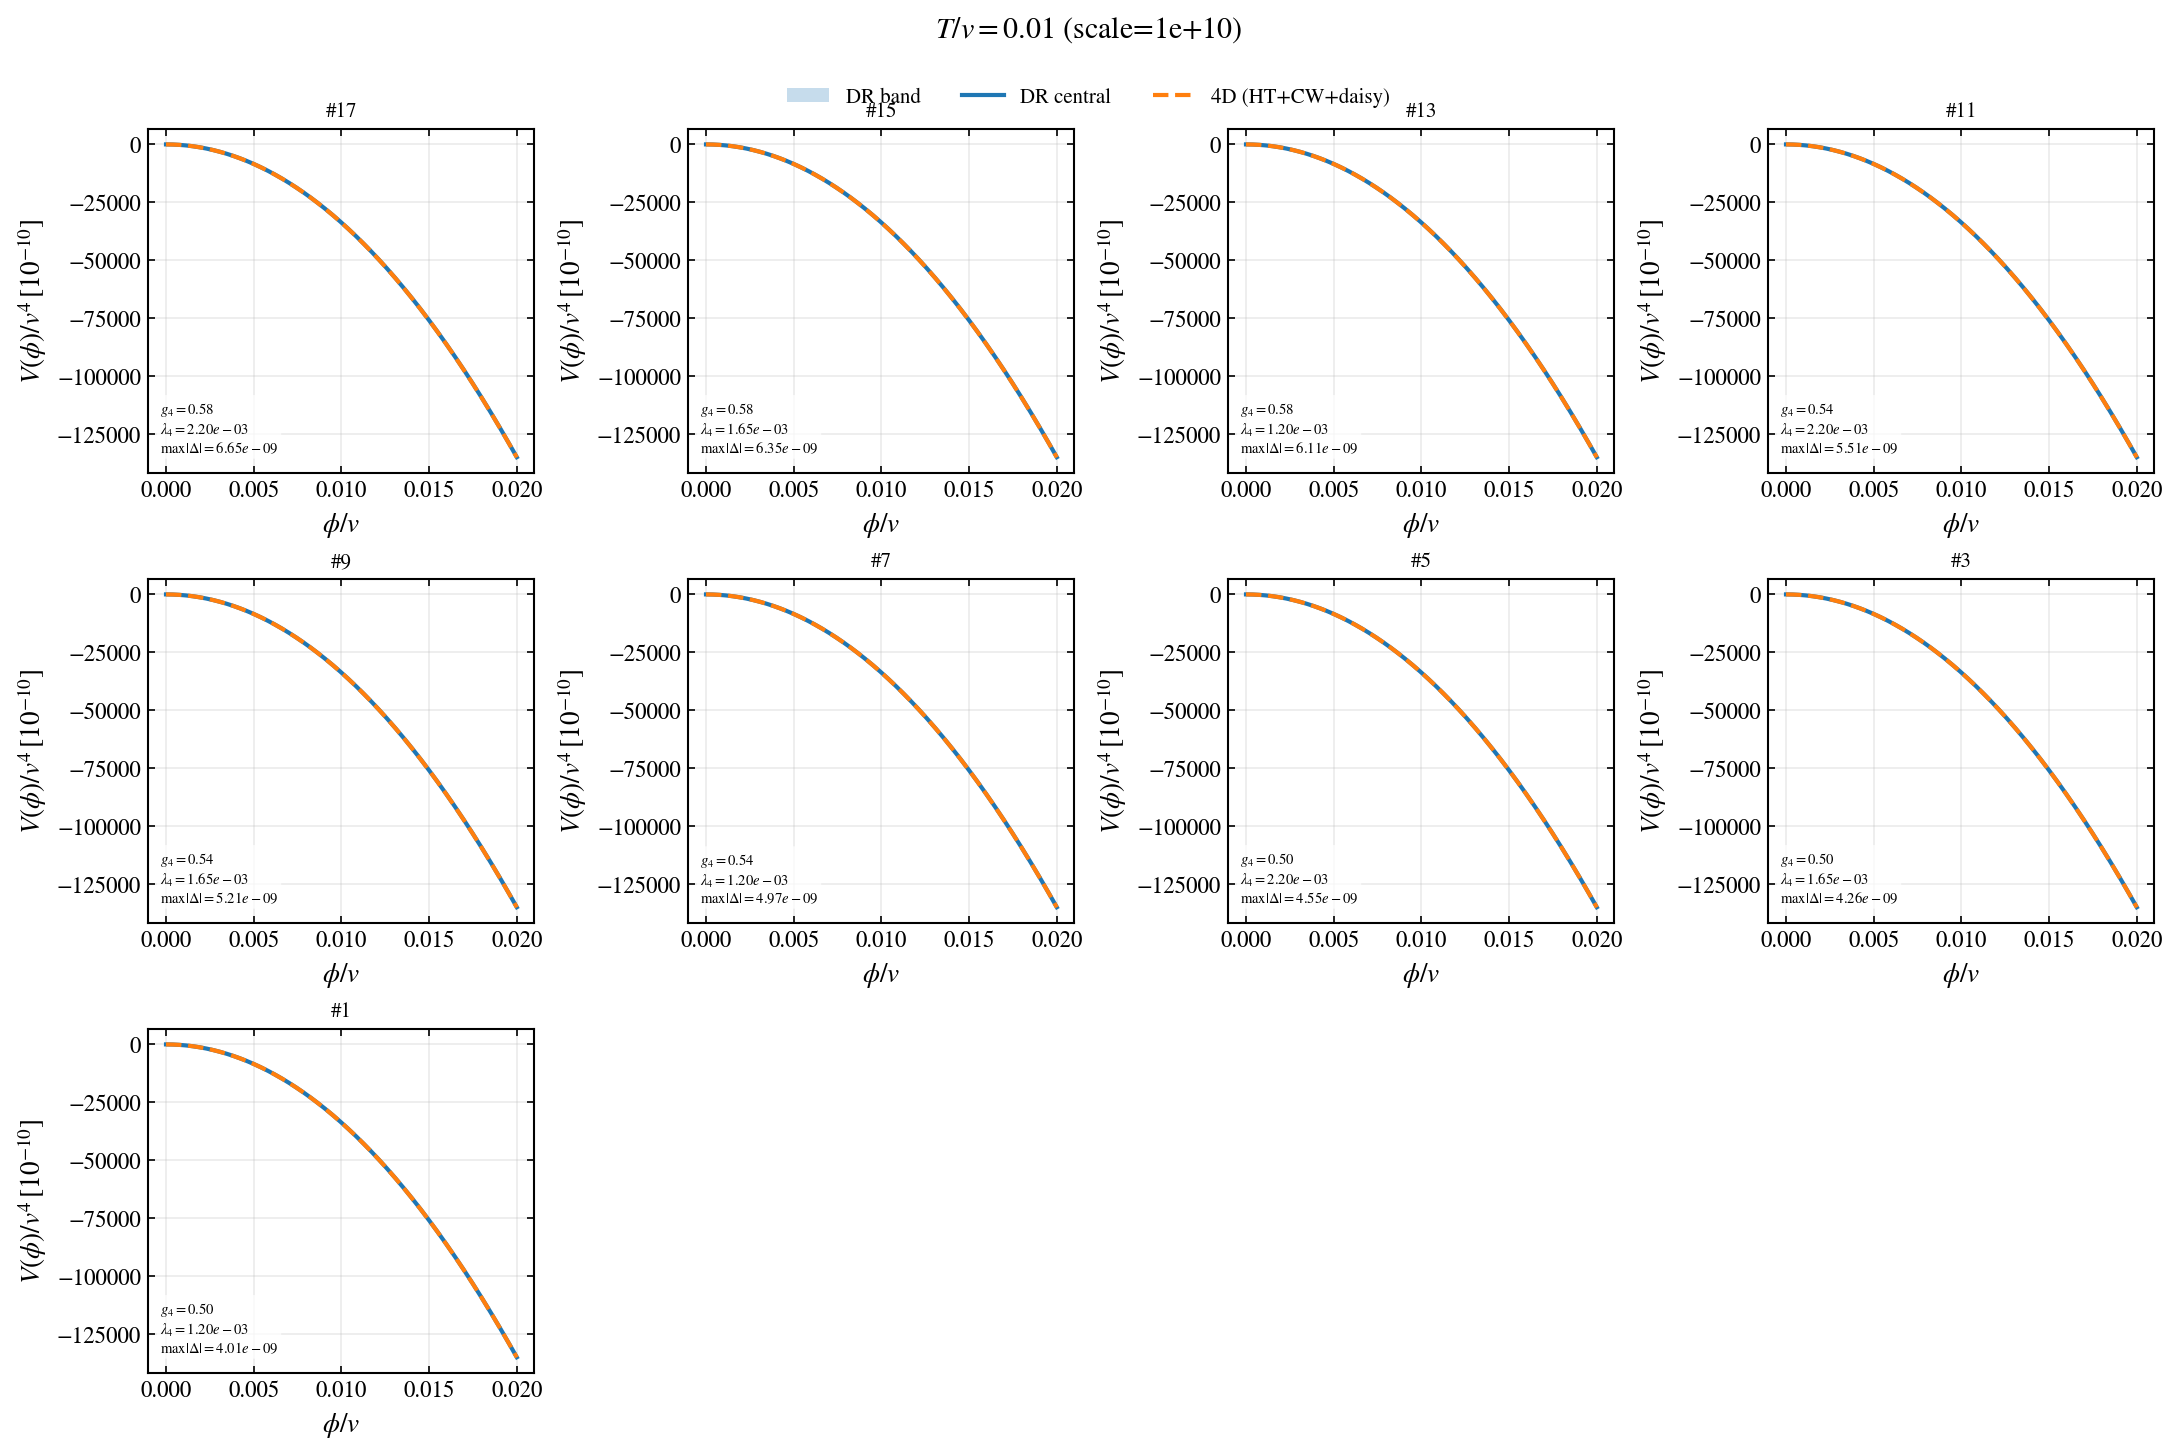

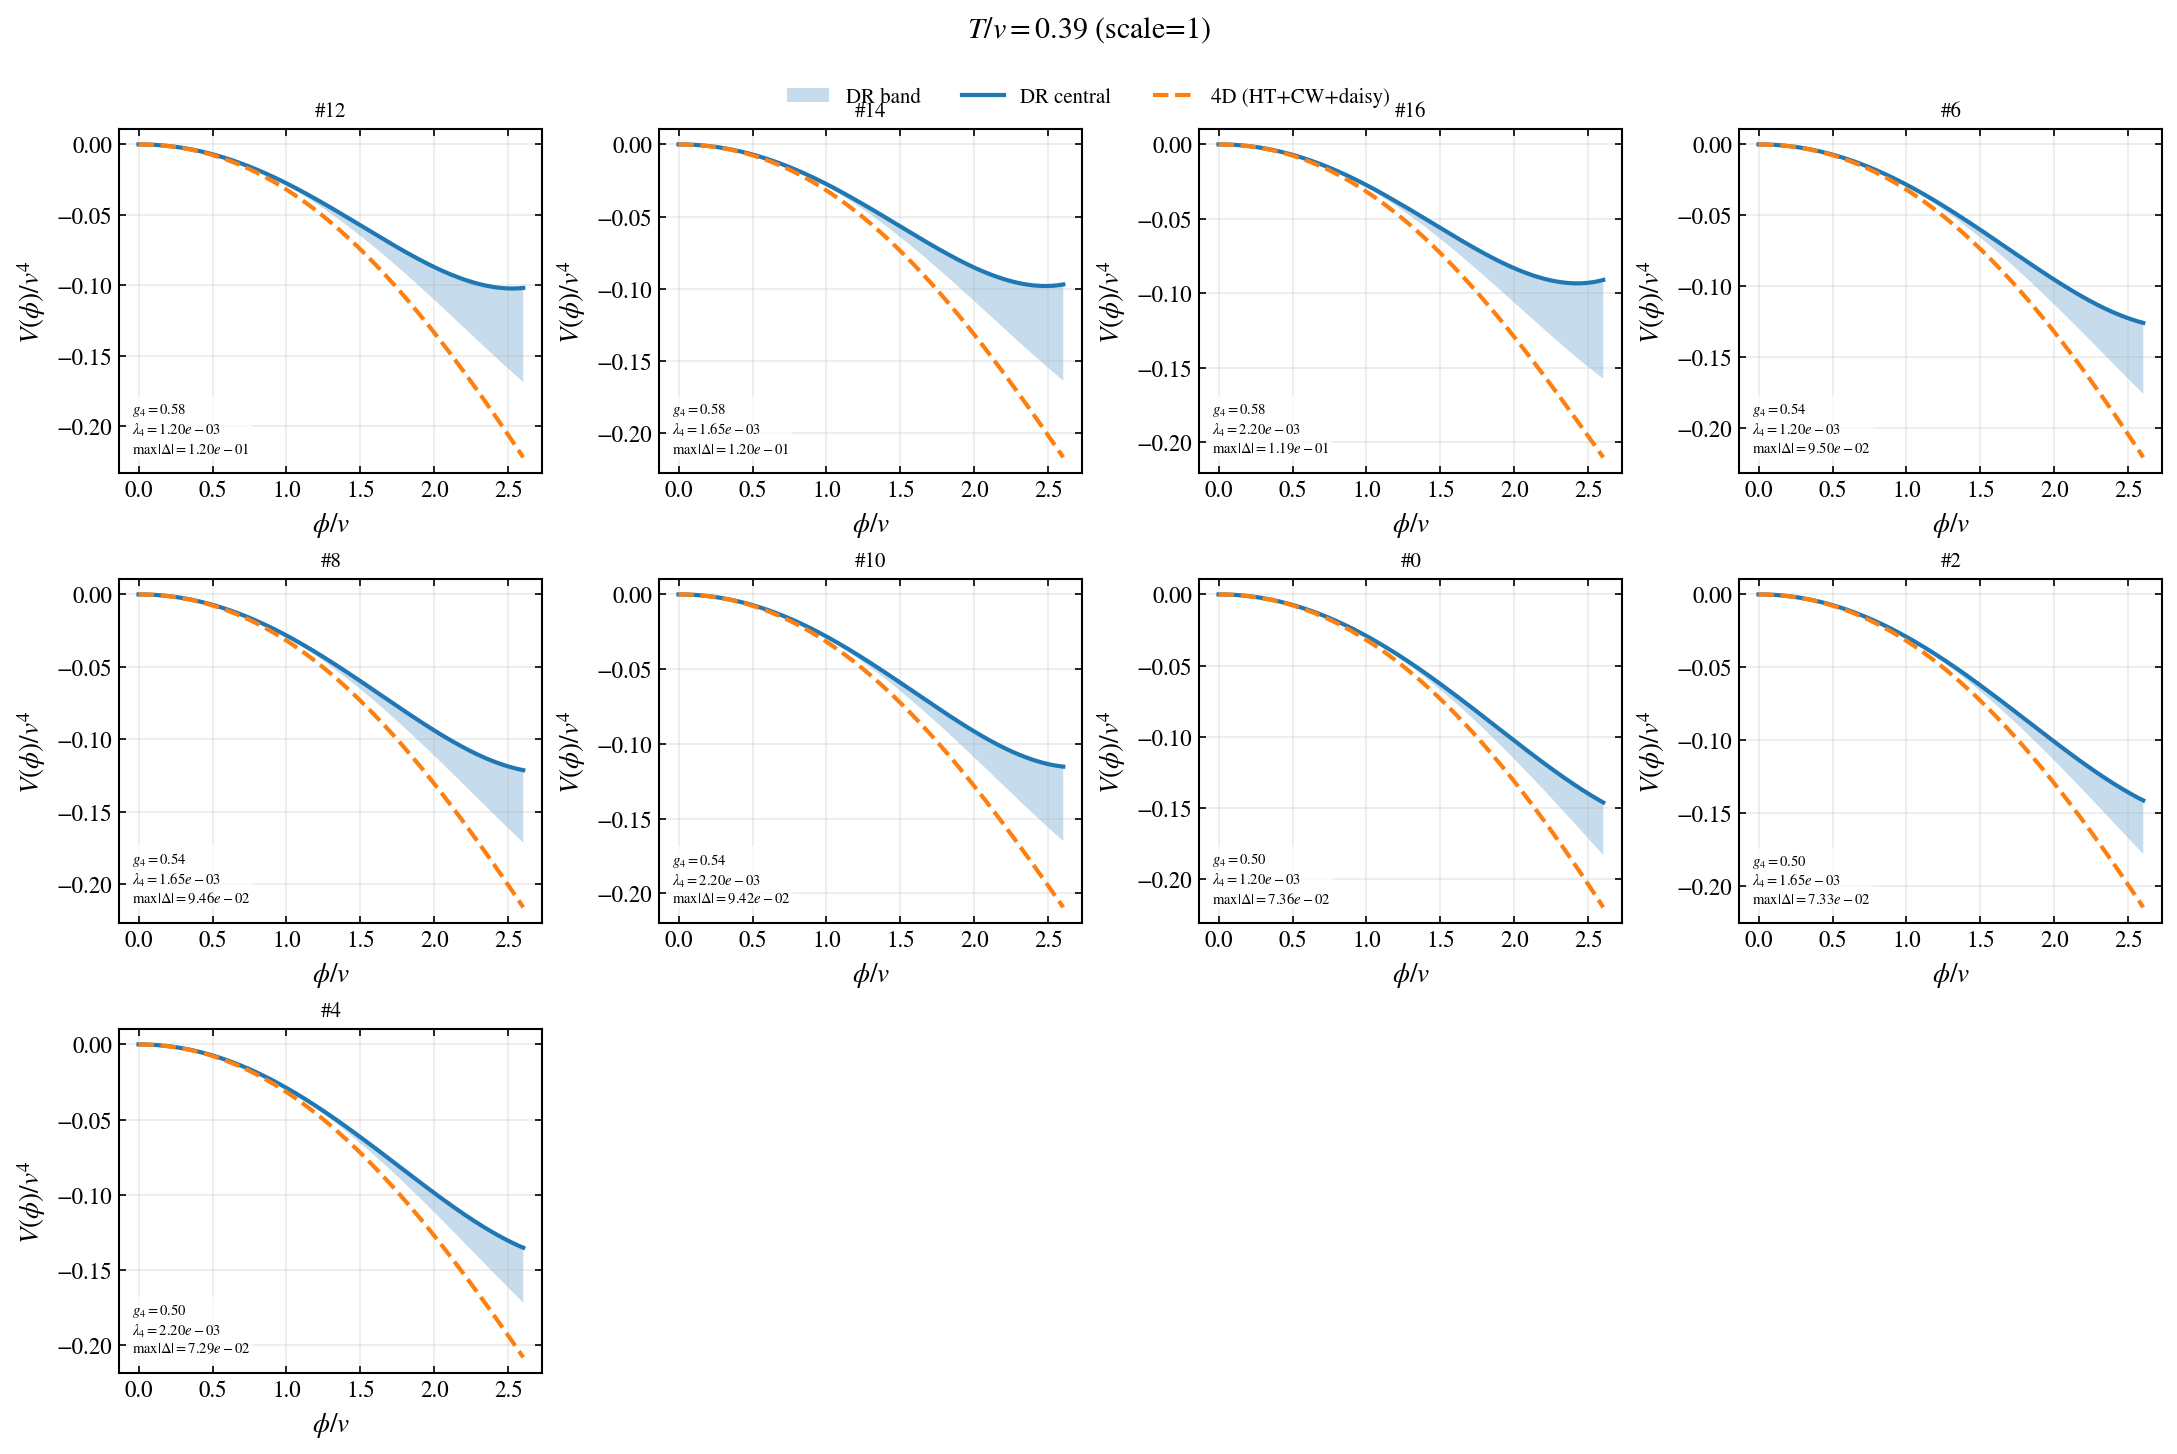

[<Figure size 2160x1350 with 12 Axes>, <Figure size 2160x1350 with 12 Axes>]

In [ ]:
plot_scan_multipanel_by_Tv(
    "my_param_scan2.npz",
     max_panels_per_group=12,
    ncols=4,
    scales_by_Tv={0.01: 1e10},
     sort_within_group="max_abs_diff",
     param_box=True,
    param_fontsize=7.0,
    param_loc="lower left",
    save="multipanel.png",
 )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _as_dict(obj):
    return obj.item() if isinstance(obj, np.ndarray) else obj

def _key_from_params(p, Tv_round=1e-6, g_round=1e-6, lam_round=1e-12, v_round=1e-6):
    Tv = float(p["T"]) / float(p["v"])
    return (
        round(Tv / Tv_round) * Tv_round,
        round(float(p["g4"]) / g_round) * g_round,
        round(float(p["lam4"]) / lam_round) * lam_round,
        round(float(p["v"]) / v_round) * v_round,
    )

def _build_index(npz_file, *, Tv_round=1e-6, g_round=1e-6, lam_round=1e-12, v_round=1e-6):
    data = np.load(npz_file, allow_pickle=True)
    curves = data["curves"]
    idx = {}
    for i in range(len(curves)):
        c = _as_dict(curves[i])
        p = c["params"]
        k = _key_from_params(p, Tv_round, g_round, lam_round, v_round)
        idx[k] = c
    return idx

def _metrics(y_ref, y_test):
    d = y_test - y_ref
    return {
        "max_abs": float(np.max(np.abs(d))),
        "rms": float(np.sqrt(np.mean(d**2))),
        "mean_abs": float(np.mean(np.abs(d))),
    }

def plot_three_way_fixed_Tv(
    npz_ht="my_param_scan.npz",
    npz_full="my_param_scan2.npz",
    *,
    Tv_target=0.39,
    pick="best_full",          # "best_full" or "best_ht" or "index"
    index_in_group=0,          # used if pick="index" after sorting
    sort_key="max_abs_diff",   # which stored metric to sort within Tv group
    sort_asc=True,
    Tv_round=1e-6,
    g_round=1e-6,
    lam_round=1e-12,
    v_round=1e-6,
    scale_by_Tv=None,          # e.g. {0.01: 1e10}
    show_band=False,           # optional DR band from HT file (Vmin/Vmax)
    save=None,
):
    # Load & index
    idx_ht   = _build_index(npz_ht,   Tv_round=Tv_round, g_round=g_round, lam_round=lam_round, v_round=v_round)
    idx_full = _build_index(npz_full, Tv_round=Tv_round, g_round=g_round, lam_round=lam_round, v_round=v_round)

    # Collect common keys near Tv_target
    Tv_key_target = round(float(Tv_target) / Tv_round) * Tv_round
    common = []
    for k in idx_ht.keys():
        if k[0] == Tv_key_target and k in idx_full:
            common.append(k)

    if not common:
        # help user: show available Tv values intersection
        Tv_common = sorted({k[0] for k in idx_ht.keys() if k in idx_full})
        raise ValueError(
            f"No common points found for Tv={Tv_key_target}. "
            f"Common available Tv keys are: {Tv_common}"
        )

    # Sort candidate points (so you can pick best or index)
    def _score(k, which):
        c = idx_full[k] if which == "full" else idx_ht[k]
        return float(c["params"].get(sort_key, np.nan))

    if pick == "best_full":
        common_sorted = sorted(common, key=lambda k: _score(k, "full"), reverse=not sort_asc)
        chosen_key = common_sorted[0]
    elif pick == "best_ht":
        common_sorted = sorted(common, key=lambda k: _score(k, "ht"), reverse=not sort_asc)
        chosen_key = common_sorted[0]
    elif pick == "index":
        common_sorted = sorted(common, key=lambda k: _score(k, "full"), reverse=not sort_asc)
        chosen_key = common_sorted[int(index_in_group)]
    else:
        raise ValueError("pick must be one of: 'best_full', 'best_ht', 'index'")

    c_ht   = idx_ht[chosen_key]
    c_full = idx_full[chosen_key]

    # Extract curves
    x   = np.asarray(c_ht["x"])
    V3  = np.asarray(c_ht["Vc"])      # DR central
    V4h = np.asarray(c_ht["V4"])      # 4D HT
    V4f = np.asarray(c_full["V4"])    # 4D HT+CW+daisy (stored as V4 in that npz)

    # Optional: DR band from HT file
    Vmin = np.asarray(c_ht.get("Vmin", V3))
    Vmax = np.asarray(c_ht.get("Vmax", V3))

    # Scale (for very small Tv you used 1e10 sometimes)
    scale = 1.0
    if scale_by_Tv:
        if Tv_key_target in scale_by_Tv:
            scale = float(scale_by_Tv[Tv_key_target])

    V3s, V4hs, V4fs = scale*V3, scale*V4h, scale*V4f
    Vmins, Vmaxs = scale*Vmin, scale*Vmax

    # Metrics vs DR (this is what you want)
    m_ht   = _metrics(V3s, V4hs)
    m_full = _metrics(V3s, V4fs)

    # Plot: top = potentials, bottom = abs deviations
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5.5, 5.2), constrained_layout=True, sharex=True)

    if show_band:
        ax0.fill_between(x, Vmins, Vmaxs, alpha=0.20, label="DR band")

    ax0.plot(x, V3s,  "-",  label="3D DR (central)")
    ax0.plot(x, V4hs, "--", label="4D (HT)")
    ax0.plot(x, V4fs, "--", label="4D (HT+CW+daisy)")

    p = c_ht["params"]
    g4  = float(p["g4"]); lam4 = float(p["lam4"]); v = float(p["v"])
    title = rf"$T/v={Tv_key_target:g}$,  $g_4={g4:.2f}$,  $\lambda_4={lam4:.2e}$,  $v={v:g}$"
    ax0.set_title(title)
    ax0.set_ylabel(r"$V(\phi)/v^4$" + (r"$\,[10^{-10}]$" if scale != 1.0 else ""))
    ax0.grid(alpha=0.25)
    ax0.legend(loc="best")

    # Deviation plots (absolute)
    ax1.plot(x, np.abs(V4hs - V3s),
             color="orange", linestyle="--", linewidth=2,
             label=rf"|HT - DR|   max={m_ht['max_abs']:.2e}, rms={m_ht['rms']:.2e}")
    ax1.plot(x, np.abs(V4fs - V3s),
             color="blue", linestyle="--", linewidth=2,
             label=rf"|FULL - DR| max={m_full['max_abs']:.2e}, rms={m_full['rms']:.2e}")

    # Set axis labels with larger font size
    ax1.set_xlabel(r"$\phi/v$", fontsize=14)
    ax1.set_ylabel(r"$|V_{4D} - V_{DR}|$", fontsize=14)

    # Increase font size for legend
    ax1.legend(loc="upper left", fontsize=12, frameon=False, labelspacing=1.1)

    # Customize the grid to make it more subtle and clean
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Set title for the plot
    ax1.set_title(r"Deviation of 4D potentials from DR", fontsize=16)

    # Customize ticks
    ax1.tick_params(axis="both", labelsize=12)

    # Adjust plot limits for clarity and focus
    ax1.set_ylim(0, np.max(np.abs(V4fs - V3s)) * 1.2)  # Add some space at the top
    ax1.set_xlim(0, max(x))  # Adjust x-axis limit as needed



    # Show the plot
    plt.show()




# Example:
# plot_three_way_fixed_Tv(
#     "my_param_scan.npz",
#     "my_param_scan2.npz",
#     Tv_target=0.39,
#     pick="best_full",          # auto-pick best match inside this Tv group
#     sort_key="max_abs_diff",
#     sort_asc=True,
#     scale_by_Tv={0.01: 1e10},
#     show_band=True,
#     save="three_way_Tv_0p39.png",
# )


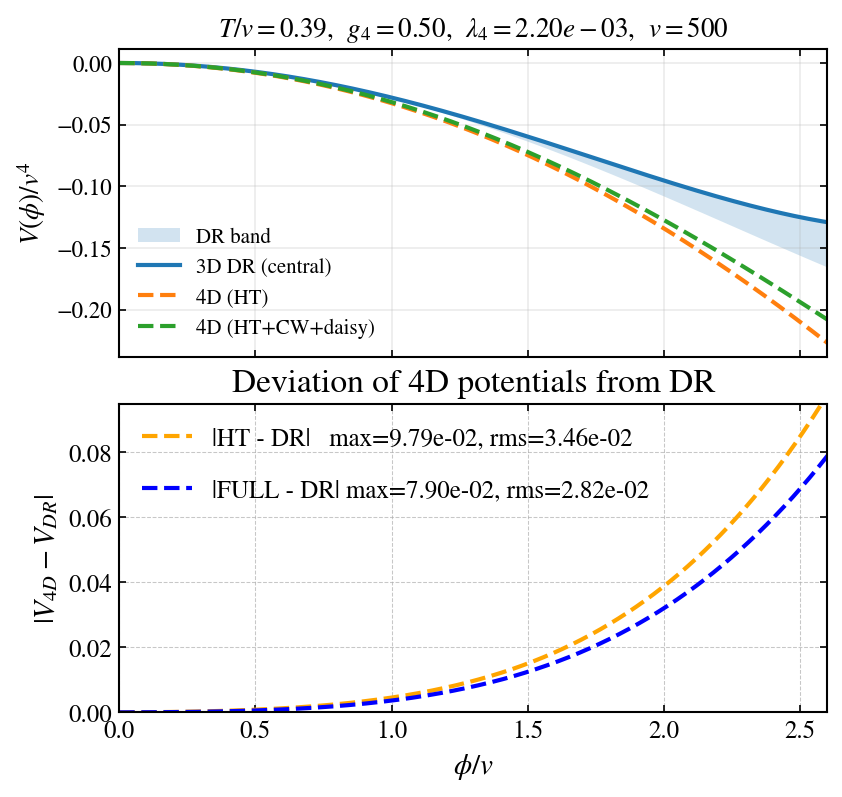

In [ ]:
plot_three_way_fixed_Tv(
    "my_param_scan.npz",
     "my_param_scan2.npz",
    Tv_target=0.39,
    pick="best_full",          # auto-pick best match inside this Tv group
    sort_key="max_abs_diff",
     sort_asc=True,
     scale_by_Tv={0.01: 1e10},
     show_band=True,
     save="three_way_Tv_0p39.png",
 )

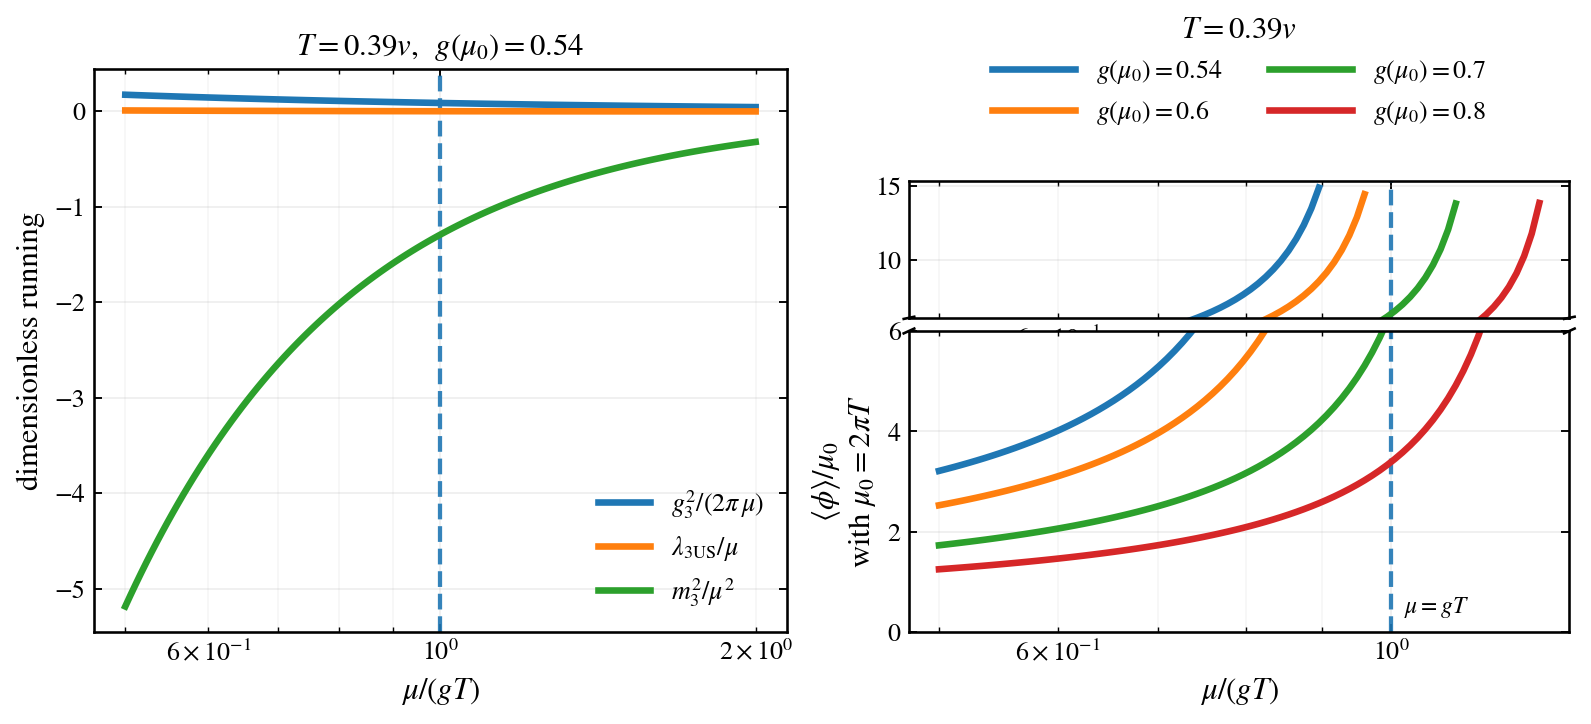

In [ ]:
#!/usr/bin/env python3
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

from potential_3d import V as V_DR
import potential_3d as dr

# -------------------------
# Publication style
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 170, "savefig.dpi": 600,
    "font.size": 12, "axes.labelsize": 13, "axes.titlesize": 13,
    "legend.fontsize": 11, "xtick.labelsize": 11, "ytick.labelsize": 11,
    "axes.linewidth": 1.1, "lines.linewidth": 2.8,
    "legend.frameon": False,
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.top": True, "ytick.right": True,
    "mathtext.fontset": "stix", "font.family": "STIXGeneral",
})

PI = np.pi
EG = np.euler_gamma


# ============================================================
# DRalgo formulas
# ============================================================
def Lb(mu, T):
    return 2 * EG - 2 * np.log(4 * PI) + np.log((mu**2) / (T**2))

def g13d_sq(muLb, T, g1, Yphi):
    L = Lb(muLb, T)
    return g1**2 * T - (g1**4 * L * T * Yphi**2) / (48.0 * PI**2)

def lam3d(muLb, T, g1, lam, Yphi):
    L = Lb(muLb, T)
    num = (
        g1**4 * (2.0 - 3.0 * L) * Yphi**4
        + 6.0 * g1**2 * L * Yphi**2 * lam
        + 2.0 * lam * (8.0 * PI**2 - 5.0 * L * lam)
    )
    return T * num / (16.0 * PI**2)

def musqU1_LO(T, g1, Yphi):
    return (g1**2 * T * T * Yphi**2) / 3.0

def musqU1_NLO(mu4, T, g1, lam, msq4, Yphi):
    g2 = g1**2
    Y2 = Yphi**2
    TT = T * T
    term = (
        36.0 * msq4
        + 7.0 * g2 * TT * Y2
        - 2.0 * EG * g2 * TT * Y2
        + 12.0 * TT * lam
        + 2.0 * g2 * TT * Y2 * np.log(4.0 * PI * T)
        - 2.0 * g2 * TT * Y2 * np.log(mu4)
    )
    return (g2 * Y2 * term) / (144.0 * PI**2)

def musqU1_resummed(mu4, T, g1, lam, msq4, Yphi, order="NLO"):
    lo = musqU1_LO(T, g1, Yphi)
    if order.upper() == "LO":
        return lo
    nlo = musqU1_NLO(mu4, T, g1, lam, msq4, Yphi)
    return nlo if (np.isfinite(nlo) and nlo > 0.0) else lo

def lambdaVL1_LO(T, g1, Yphi):
    return (g1**4 * T * Yphi**4) / (PI**2)

def lambdaVL1_NLO(muLb, T, g1, lam, Yphi):
    L = Lb(muLb, T)
    g2 = g1**2
    Y2 = Yphi**2
    num = (48.0 * PI**2 - g2 * (-4.0 + L) * Y2 + 24.0 * lam)
    return (g2 * T * Y2 * num) / (24.0 * PI**2)

def lambdaVL1(muLb, T, g1, lam, Yphi, order="NLO"):
    return lambdaVL1_LO(T, g1, Yphi) if order.upper() == "LO" else lambdaVL1_NLO(muLb, T, g1, lam, Yphi)

def lam3dUS(muLb, mu4, T, g1, lam, msq4, Yphi, order_mU1="NLO", order_lamVL="NLO"):
    lam3 = lam3d(muLb, T, g1, lam, Yphi)
    muU1sq = musqU1_resummed(mu4, T, g1, lam, msq4, Yphi, order=order_mU1)
    muU1 = np.sqrt(max(muU1sq, 1e-30))
    lamVL = lambdaVL1(muLb, T, g1, lam, Yphi, order=order_lamVL)
    return lam3 - (lamVL**2) / (32.0 * PI * muU1)

def beta_m3sq(muLb, mu4, T, g1, lam, msq4, Yphi, order_mU1="NLO", order_lamVL="NLO"):
    g3sq = g13d_sq(muLb, T, g1, Yphi)
    lamUS = lam3dUS(muLb, mu4, T, g1, lam, msq4, Yphi, order_mU1, order_lamVL)
    return ((g3sq**2) * Yphi**4 - 2.0 * g3sq * Yphi**2 * lamUS + 2.0 * lamUS**2) / (4.0 * PI**2)

def integrate_m3sq_from_mu0(mu0, mu_desc, mu4, T, g1, lam, msq4, Yphi,
                            m3sq_mu0, muLb_of_mu,
                            order_mU1="NLO", order_lamVL="NLO"):
    mu_grid = np.concatenate(([mu0], mu_desc))
    ln = np.log(mu_grid)
    m3 = np.empty_like(mu_grid)
    m3[0] = float(m3sq_mu0)

    for i in range(len(mu_grid) - 1):
        dln = ln[i + 1] - ln[i]
        mu_i  = mu_grid[i]
        mu_h  = mu_grid[i] * np.exp(0.5 * dln)
        mu_ip = mu_grid[i + 1]

        k1 = beta_m3sq(muLb_of_mu(mu_i),  mu4, T, g1, lam, msq4, Yphi, order_mU1, order_lamVL)
        k2 = beta_m3sq(muLb_of_mu(mu_h),  mu4, T, g1, lam, msq4, Yphi, order_mU1, order_lamVL)
        k3 = beta_m3sq(muLb_of_mu(mu_h),  mu4, T, g1, lam, msq4, Yphi, order_mU1, order_lamVL)
        k4 = beta_m3sq(muLb_of_mu(mu_ip), mu4, T, g1, lam, msq4, Yphi, order_mU1, order_lamVL)

        m3[i + 1] = m3[i] + (dln / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return m3[1:]


# ============================================================
# DR param setter + VEV finder (non-runaway)
# ============================================================
def set_dr_params(mu3US, g1_3d, lam3US_val, m3sq_val, Yphi):
    def _gp(_T):
        return dict(Yphi=float(Yphi), g1=float(g1_3d), lam=float(lam3US_val),
                    msq=float(m3sq_val), mu3US=float(mu3US))
    dr.get_params = _gp

def vev_phi3_safe(
    T, mu3US, g1_3d, lam3US_val, m3sq_val, Yphi,
    phi3_max0, nphi=1600, phi_floor=1e-8,
    grow=1.8, max_grows=2,
):
    set_dr_params(mu3US, g1_3d, lam3US_val, m3sq_val, Yphi)
    phi_max = float(phi3_max0)

    for _ in range(max_grows + 1):
        phi = np.linspace(phi_floor, phi_max, int(nphi))
        V = V_DR(phi, T)
        i = int(np.nanargmin(V))

        if i <= 1:
            return 0.0, True

        if i >= len(phi) - 2:
            if V[-1] < V[-10]:
                phi_max *= grow
                continue
            return float(phi[i]), True

        xs = phi[i-1:i+2]
        ys = V[i-1:i+2]
        try:
            a, b, c = np.polyfit(xs, ys, 2)
            if a > 0:
                xstar = -b/(2*a)
                if xs[0] <= xstar <= xs[-1]:
                    return float(xstar), True
        except Exception:
            pass

        return float(phi[i]), True

    return np.nan, False


# ============================================================
# Broken-axis helper
# ============================================================
def add_break_marks(ax_top, ax_bot, d=0.008):
    kw = dict(color="k", clip_on=False, linewidth=1.1)
    ax_top.plot((-d, +d), (-d, +d), transform=ax_top.transAxes, **kw)
    ax_top.plot((1-d, 1+d), (-d, +d), transform=ax_top.transAxes, **kw)
    ax_bot.plot((-d, +d), (1-d, 1+d), transform=ax_bot.transAxes, **kw)
    ax_bot.plot((1-d, 1+d), (1-d, 1+d), transform=ax_bot.transAxes, **kw)


# ============================================================
# Main figure (legend row dedicated)
# ============================================================
def make_fig_mu_over_gT_broken(
    *,
    v=500.0,
    T_over_v=0.39,
    Yphi=1.0,
    lam4=1.65e-3,
    m0sq4=-(130.0**2),

    g_for_left=0.54,
    g_list=(0.54, 0.6, 0.7, 0.8),

    x_soft=(0.5, 2.0),
    n_x=120,

    mu0_factor=2*np.pi,   # mu0 = 2πT
    mu4_factor=np.pi,     # mu4 = πT

    Lb_scale="mu3",       # "mu3" or "mu0"
    order_mU1="NLO",
    order_lamVL="NLO",

    phi4_max_factor=12.0,
    nphi=1600,

    y_break=6.0,
    save_prefix="fig_mu_over_gT_brokenY_cleanlegend"
):
    v = float(v)
    T = float(T_over_v) * v
    mu0 = float(mu0_factor) * T
    mu4 = float(mu4_factor) * T

    x = np.logspace(np.log10(x_soft[0]), np.log10(x_soft[1]), int(n_x))

    if Lb_scale == "mu3":
        muLb_of_mu = lambda mu: mu
    elif Lb_scale == "mu0":
        muLb_of_mu = lambda mu: mu0
    else:
        raise ValueError("Lb_scale must be 'mu3' or 'mu0'")

    orig_gp = dr.get_params

    # ---- layout: left spans full height, right has a small legend row + broken axis plot
    fig = plt.figure(figsize=(11.2, 4.3))
    gs = GridSpec(
        2, 2, figure=fig,
        height_ratios=[0.20, 1.0],
        width_ratios=[1.05, 1.0],
        wspace=0.18, hspace=0.08
    )

    axL   = fig.add_subplot(gs[:, 0])   # spans both rows
    axLeg = fig.add_subplot(gs[0, 1])   # legend-only row
    axLeg.axis("off")

    gsR = gs[1, 1].subgridspec(2, 1, height_ratios=[1.0, 2.2], hspace=0.06)
    axRt = fig.add_subplot(gsR[0, 0])
    axRb = fig.add_subplot(gsR[1, 0], sharex=axRt)

    # common cosmetics
    for ax in (axL, axRt, axRb):
        ax.set_xscale("log")
        ax.axvline(1.0, linestyle="--", linewidth=1.8, alpha=0.9)
        ax.grid(True, which="major", alpha=0.20)
        ax.grid(True, which="minor", alpha=0.10)

    axRt.tick_params(labelbottom=False)

    # ---------------- LEFT panel ----------------
    g0 = float(g_for_left)
    muL = x * g0 * T
    muLbL = muLb_of_mu(muL)

    g3sq_L  = g13d_sq(muLbL, T, g0, Yphi)
    lamUS_L = lam3dUS(muLbL, mu4, T, g0, lam4, m0sq4, Yphi, order_mU1=order_mU1, order_lamVL=order_lamVL)

    # IC for m3^2 at mu0 (placeholder)
    Pi_LO = (lam4/3.0 + (g0*g0*Yphi*Yphi)/4.0) * T*T
    m3sq_mu0 = float(m0sq4) + Pi_LO

    mu_desc = np.sort(muL)[::-1]
    m3_desc = integrate_m3sq_from_mu0(
        mu0, mu_desc, mu4, T, g0, lam4, m0sq4, Yphi, m3sq_mu0,
        muLb_of_mu=muLb_of_mu, order_mU1=order_mU1, order_lamVL=order_lamVL
    )
    m3sq_L = np.interp(muL, mu_desc[::-1], m3_desc[::-1])

    axL.plot(x, g3sq_L/(2.0*PI*muL), label=r"$g_3^2/(2\pi\,\mu)$")
    axL.plot(x, lamUS_L/muL,         label=r"$\lambda_{3\mathrm{US}}/\mu$")
    axL.plot(x, m3sq_L/(muL*muL),    label=r"$m_3^2/\mu^2$")

    axL.set_xlabel(r"$\mu/(gT)$")
    axL.set_ylabel("dimensionless running")
    axL.set_title(rf"$T={T_over_v:g}v,\;\; g(\mu_0)={g0:g}$")
    axL.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axL.legend(loc="lower right")

    # ---------------- RIGHT panel (broken y) ----------------
    phi3_max0 = (float(phi4_max_factor) * v) / np.sqrt(T)

    curves = []
    for gcur in map(float, g_list):
        muR = x * gcur * T
        muLbR = muLb_of_mu(muR)

        g3sq_R  = g13d_sq(muLbR, T, gcur, Yphi)
        lamUS_R = lam3dUS(muLbR, mu4, T, gcur, lam4, m0sq4, Yphi, order_mU1=order_mU1, order_lamVL=order_lamVL)

        Pi_LO_r = (lam4/3.0 + (gcur*gcur*Yphi*Yphi)/4.0) * T*T
        m3sq_mu0_r = float(m0sq4) + Pi_LO_r

        mu_desc = np.sort(muR)[::-1]
        m3_desc = integrate_m3sq_from_mu0(
            mu0, mu_desc, mu4, T, gcur, lam4, m0sq4, Yphi, m3sq_mu0_r,
            muLb_of_mu=muLb_of_mu, order_mU1=order_mU1, order_lamVL=order_lamVL
        )
        m3sq_R = np.interp(muR, mu_desc[::-1], m3_desc[::-1])

        vev4 = np.full_like(x, np.nan, dtype=float)
        ok = np.ones_like(x, dtype=bool)

        for i in range(len(x)):
            g1_3d = np.sqrt(max(g3sq_R[i], 0.0))
            phi3, good = vev_phi3_safe(
                T, muR[i], g1_3d, lamUS_R[i], m3sq_R[i], Yphi,
                phi3_max0=phi3_max0, nphi=nphi
            )
            ok[i] = bool(good) and np.isfinite(phi3)
            vev4[i] = np.sqrt(T) * phi3 if ok[i] else np.nan

        y = vev4 / mu0
        curves.append((rf"$g(\mu_0)={gcur:g}$", x[ok], y[ok]))

    # y-lims for broken axis
    all_y = np.concatenate([yy for _, _, yy in curves if len(yy) > 0]) if curves else np.array([])
    y_max = float(np.nanmax(all_y)) if (all_y.size and np.isfinite(np.nanmax(all_y))) else (y_break * 2.0)
    y_top_min = y_break * 1.02
    y_top_max = y_max * 1.03

    # plot
    handles = []
    labels = []
    for lab, xx, yy in curves:
        ln, = axRb.plot(xx, yy, label=lab)
        axRt.plot(xx, yy, color=ln.get_color())
        handles.append(ln); labels.append(lab)

    axRb.set_ylim(0.0, y_break)
    axRt.set_ylim(y_top_min, y_top_max)

    axRb.set_xlabel(r"$\mu/(gT)$")
    axRb.set_ylabel(r"$\langle\phi\rangle/\mu_0$" + "\n" + r"with $\mu_0=2\pi T$")
    axRb.text(1.02, 0.04, r"$\mu=gT$", transform=axRb.get_xaxis_transform(),
              fontsize=10, va="bottom", ha="left")

    axRt.set_title("")  # title goes to legend row
    axLeg.text(0.5, 1.58, rf"$T={T_over_v:g}v$", ha="center", va="top", fontsize=13)

    # legend in dedicated legend row (no overlap possible)
    axLeg.legend(handles, labels, loc="lower center", ncols=2,
                 columnspacing=1.8, handlelength=3.2, bbox_to_anchor=(0.5, 0.10))

    add_break_marks(axRt, axRb)

    # save/show
    dr.get_params = orig_gp
    fig.savefig(save_prefix + ".pdf", bbox_inches="tight")
    fig.savefig(save_prefix + ".png", bbox_inches="tight")
    plt.show()


# ---------------- RUN ----------------
make_fig_mu_over_gT_broken(
    v=500.0,
    T_over_v=0.39,
    g_for_left=0.54,
    g_list=(0.54, 0.6, 0.7, 0.8),
    x_soft=(0.5, 2.0),
    n_x=120,
    Lb_scale="mu3",
    order_mU1="NLO",
    order_lamVL="NLO",
    phi4_max_factor=12.0,
    nphi=1600,
    y_break=6.0,
    save_prefix="fig_mu_over_gT_brokenY_cleanlegend"
)
